In [31]:
import pickle

import numpy as np
import random
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics.cluster import completeness_score, homogeneity_score
from scipy.stats import bootstrap, ttest_rel
from sklearn.metrics import adjusted_rand_score, silhouette_score

from utils import stats

### Load data

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.RandomState(RANDOM_SEED)

sns.set_theme("paper")
sns.set_context("talk")

In [4]:
with open("pickles_and_csvs/cluster_labels_embeddings_and_nn_graphs_95.pkl", "rb") as file:
    clusters_dict_l2_95 = pickle.load(file)
    clusters_dict_l2_95["n"] = 95
    clusters_dict_l2_95["distance_metric"] = "l2"
    clusters_dict_l2_95["alarm"] = "yes"

with open("pickles_and_csvs/cluster_labels_embeddings_and_nn_graphs_L1_95.pkl", "rb") as file:
    clusters_dict_l1_95 = pickle.load(file)
    clusters_dict_l1_95["n"] = 95
    clusters_dict_l1_95["distance_metric"] = "l1"
    clusters_dict_l1_95["alarm"] = "yes"

with open("pickles_and_csvs/cluster_labels_embeddings_and_nn_graphs_200.pkl", "rb") as file:
    clusters_dict_l2_200 = pickle.load(file)
    clusters_dict_l2_200["n"] = 200
    clusters_dict_l2_200["distance_metric"] = "l2"
    clusters_dict_l2_200["alarm"] = "yes"

with open("pickles_and_csvs/cluster_labels_embeddings_and_nn_graphs_500.pkl", "rb") as file:
    clusters_dict_l2_500 = pickle.load(file)
    clusters_dict_l2_500["n"] = 500
    clusters_dict_l2_500["distance_metric"] = "l2"
    clusters_dict_l2_500["alarm"] = "yes"

with open("pickles_and_csvs/cluster_labels_embeddings_and_nn_graphs_500_wo_alarm.pkl", "rb") as file:
    clusters_dict_l2_500_no_alarm = pickle.load(file)
    clusters_dict_l2_500_no_alarm["n"] = 500
    clusters_dict_l2_500_no_alarm["distance_metric"] = "l2"
    clusters_dict_l2_500_no_alarm["alarm"] = "no"

Tue Feb 11 12:49:14 2025 Building and compiling search function
Tue Feb 11 12:49:16 2025 Building and compiling search function
Tue Feb 11 12:49:17 2025 Building and compiling search function
Tue Feb 11 12:49:18 2025 Building and compiling search function
Tue Feb 11 12:49:21 2025 Building and compiling search function
Tue Feb 11 12:49:22 2025 Building and compiling search function
Tue Feb 11 12:49:23 2025 Building and compiling search function
Tue Feb 11 12:49:24 2025 Building and compiling search function
Tue Feb 11 12:49:26 2025 Building and compiling search function
Tue Feb 11 12:49:28 2025 Building and compiling search function
Tue Feb 11 12:49:29 2025 Building and compiling search function
Tue Feb 11 12:49:31 2025 Building and compiling search function
Tue Feb 11 12:49:33 2025 Building and compiling search function
Tue Feb 11 12:49:35 2025 Building and compiling search function
Tue Feb 11 12:49:37 2025 Building and compiling search function
Tue Feb 11 12:49:38 2025 Building and co

In [5]:
representation_keys = ["PAFs", "LFCCs", "Spectrograms", "VAE representations"]
algorithm_keys = ["kMeans", "kMeans-preset", "HDBSCAN", "Leiden"]
dicts = [clusters_dict_l2_95, clusters_dict_l1_95, clusters_dict_l2_200, clusters_dict_l2_500, clusters_dict_l2_500_no_alarm]

##### Hopkins statistic

In [6]:
rows = []
for di in dicts:
    for representation in representation_keys:
        rows.append([di["n"], di["distance_metric"], di["alarm"], representation, stats.hopkins(di[representation]["embeddings"], RANDOM_SEED)])

hopkins_results = pd.DataFrame(
    rows, 
    columns=["N subsets", "Distance metric", "Alarm call subset", "Representation", "Hopkins"]
)

hopkins_results

N subsets Distance metric Alarm call subset       Representation   Hopkins
0          95              l2               yes                 PAFs  0.930656
1          95              l2               yes                LFCCs  0.984544
2          95              l2               yes         Spectrograms  0.879741
3          95              l2               yes  VAE representations  0.944052
4          95              l1               yes                 PAFs  0.911853
5          95              l1               yes                LFCCs  0.967912
6          95              l1               yes         Spectrograms  0.876516
7          95              l1               yes  VAE representations  0.927955
8         200              l2               yes                 PAFs  0.920632
9         200              l2               yes                LFCCs  0.977769
10        200              l2               yes         Spectrograms  0.920316
11        200              l2               yes  VAE representations  0.944868
12        500              l2               yes                 PAFs  0.973390
13        500              l2               yes                LFCCs  0.991976
14        500              l2               yes         Spectrograms  0.963127
15        500              l2               yes  VAE representations  0.961667
16        500              l2                no                 PAFs  0.965982
17        500              l2                no                LFCCs  0.990325
18        500              l2                no         Spectrograms  0.962600
19        500              l2                no  VAE representations  0.962779

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_48175/1200136567.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hopkins_filtered = hopkins_filtered[hopkins_results["Alarm call subset"] != "no"]


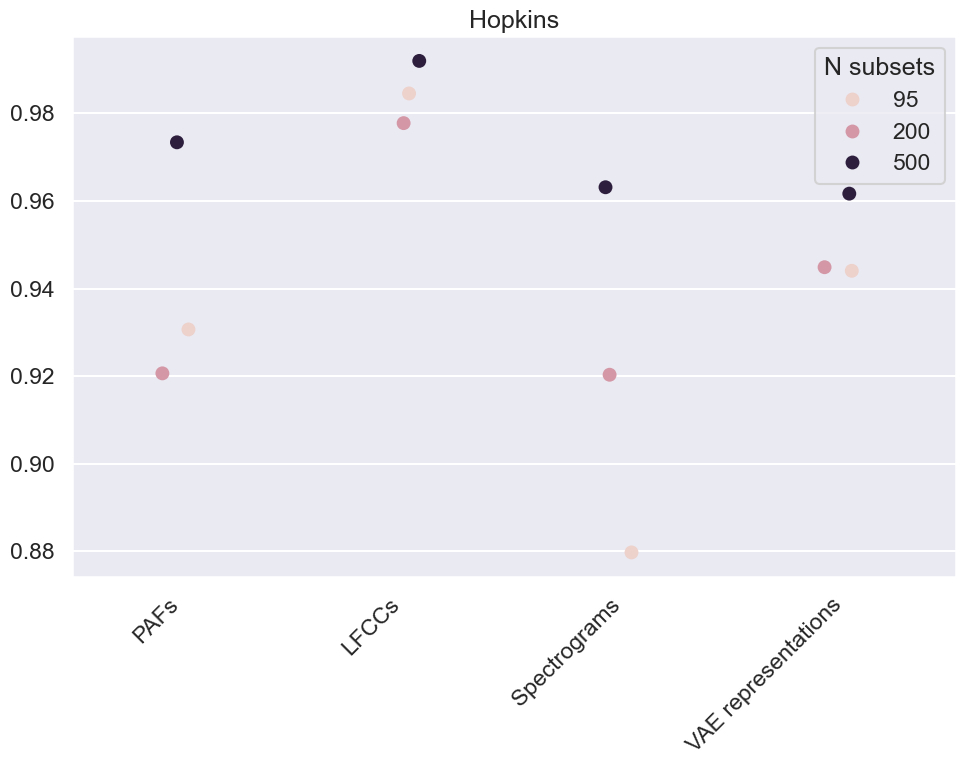

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
hopkins_filtered = hopkins_results[hopkins_results["Distance metric"] != "l1"]
hopkins_filtered = hopkins_filtered[hopkins_results["Alarm call subset"] != "no"]

# Raw data points
sns.stripplot(
    x="Representation", 
    y="Hopkins", 
    data=hopkins_filtered,
    ax=ax, 
    jitter=True, 
    size=10, 
    hue="N subsets", 
    legend=True
)

ax.set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
ax.set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
ax.set_title("Hopkins")
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.show()

##### Silhouette score and modularity

In [8]:
rows = []

for di in dicts:
    for representation in representation_keys:
        for algorithm in algorithm_keys:
            if algorithm == "Leiden":
                rows.append([
                    di["n"], 
                    di["distance_metric"], 
                    di["alarm"], 
                    representation, 
                    algorithm, 
                    None, 
                    None, 
                    None, 
                    di[representation]["Modularity"]
                    ])
                continue
            krusk_res = stats.silhouette_against_chance(di[representation][algorithm], di[representation]["embeddings"])
            rows.append([
                di["n"], 
                di["distance_metric"], 
                di["alarm"],
                representation, 
                algorithm, 
                silhouette_score(di[representation]["embeddings"], di[representation][algorithm]),
                krusk_res.statistic,
                krusk_res.pvalue, 
                None
                ])

clusterability_results = pd.DataFrame(
    rows, 
    columns=["N subsets", "Distance metric", "Alarm call subset", "Representation", "Algorithm", "Silhouette Score", "Silhouette score - Kruskal statistic", "Silhouette score - Kruskal p-value", "Modularity"]
)

clusterability_results

N subsets Distance metric Alarm call subset       Representation  \
0          95              l2               yes                 PAFs   
1          95              l2               yes                 PAFs   
2          95              l2               yes                 PAFs   
3          95              l2               yes                 PAFs   
4          95              l2               yes                LFCCs   
..        ...             ...               ...                  ...   
75        500              l2                no         Spectrograms   
76        500              l2                no  VAE representations   
77        500              l2                no  VAE representations   
78        500              l2                no  VAE representations   
79        500              l2                no  VAE representations   

        Algorithm  Silhouette Score  Silhouette score - Kruskal statistic  \
0          kMeans          0.546160                            844.188924   
1   kMeans-preset          0.545690                            847.330526   
2         HDBSCAN          0.464212                            674.921008   
3          Leiden               NaN                                   NaN   
4          kMeans          0.704687                            855.750656   
..            ...               ...                                   ...   
75         Leiden               NaN                                   NaN   
76         kMeans          0.729418                           3712.990349   
77  kMeans-preset          0.443599                           3601.936560   
78        HDBSCAN          0.720531                           3720.750151   
79         Leiden               NaN                                   NaN   

    Silhouette score - Kruskal p-value  Modularity  
0                        1.333250e-185         NaN  
1                        2.766411e-186         NaN  
2                        8.500370e-149         NaN  
3                                  NaN    0.706141  
4                        4.086641e-188         NaN  
..                                 ...         ...  
75                                 NaN    0.729908  
76                        0.000000e+00         NaN  
77                        0.000000e+00         NaN  
78                        0.000000e+00         NaN  
79                                 NaN    0.729196  

[80 rows x 9 columns]

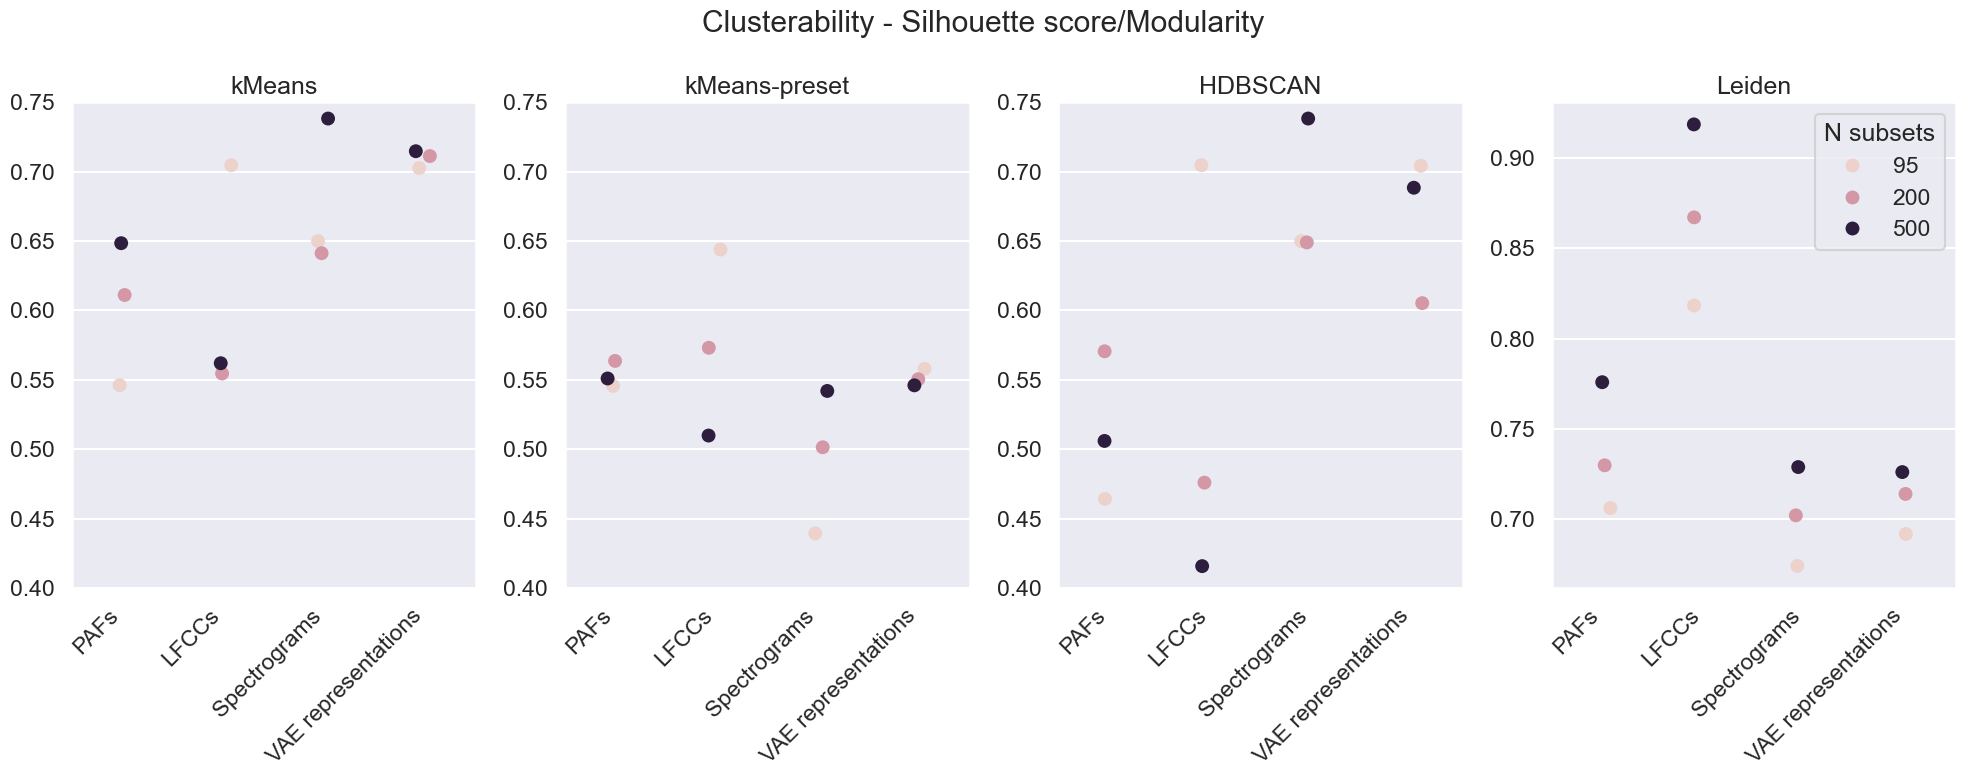

In [9]:
clusterability_results_filtered = clusterability_results[clusterability_results["Alarm call subset"]=="yes"]
clusterability_results_filtered = clusterability_results_filtered[clusterability_results_filtered["Distance metric"]=="l2"]
fig, axs = plt.subplots(ncols=4, figsize=(20, 8))

columns = ["kMeans", "kMeans-preset", "HDBSCAN", "Leiden"]
for i, column in enumerate(columns):
    # Raw data points
    sns.stripplot(
        x="Representation", 
        y="Silhouette Score" if column!= "Leiden" else "Modularity", 
        data=clusterability_results_filtered[clusterability_results_filtered["Algorithm"]==column], 
        ax=axs[i], 
        jitter=True, 
        size=10, 
        hue="N subsets", 
        legend=(True if i == len(columns)-1 else False)
    )
    # # Mean points
    # sns.pointplot(
    #     x="Representation", 
    #     y=column, 
    #     data=clusterability_results, 
    #     ax=axs[i], 
    #     errorbar=None,
    #     markers="o", 
    #     color="grey",
    #     alpha=0.3
    # )

    if column!= "Leiden":
        axs[i].set_ylim(.4,.75)
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

fig.suptitle("Clusterability - Silhouette score/Modularity")
plt.tight_layout()
plt.show()

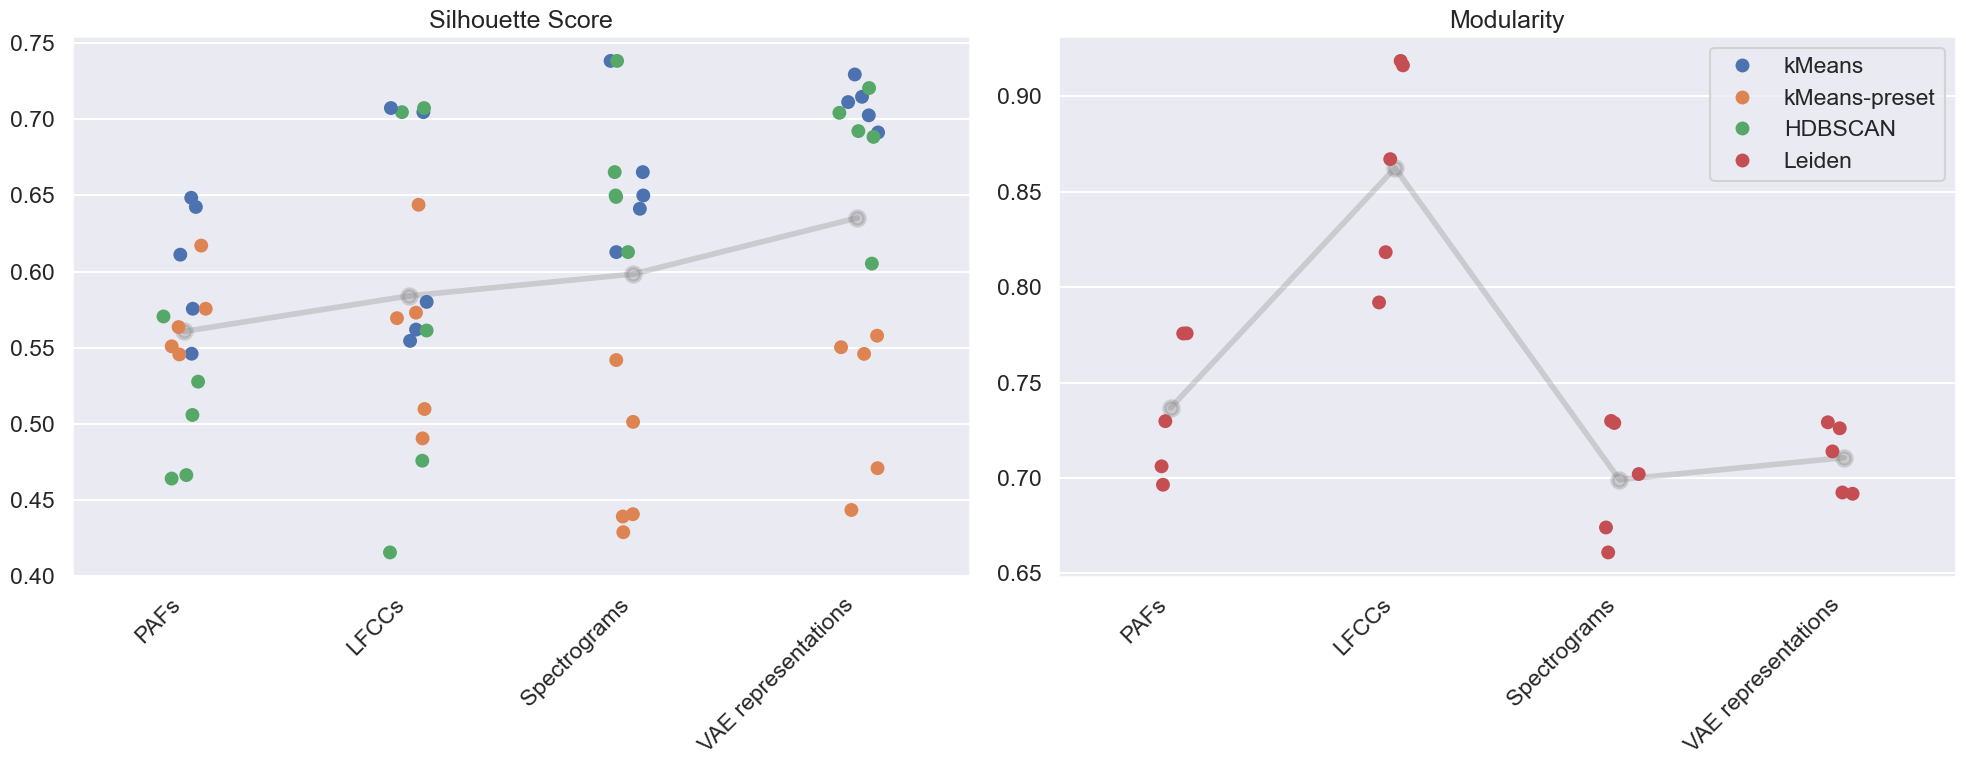

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["Silhouette Score", "Modularity"]
for i, column in enumerate(columns):
    # Raw data points
    sns.stripplot(
        x="Representation", 
        y=column, 
        data=clusterability_results, 
        ax=axs[i], 
        jitter=True, 
        size=10, 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False)
    )
    # Mean points
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=clusterability_results, 
        ax=axs[i], 
        errorbar=None,
        markers="o", 
        color="grey",
        alpha=0.3
    )

    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()

##### True labels vs predicted labels

In [11]:
rows = []
for di in dicts:
    for representation in representation_keys:
        for algorithm in algorithm_keys:
            _, _, _, _, p_value, chance_level, distribution = stats.v_measure_against_chance(
                di["true_labels"], 
                di[representation][algorithm],  
                plot=False)
            
            rows.append([
                di["n"], 
                di["distance_metric"], 
                di["alarm"],
                representation,
                algorithm,
                p_value,
                chance_level, 
                distribution,
                bootstrap((di["true_labels"], di[representation][algorithm]), homogeneity_score, n_resamples=1000, paired=True).bootstrap_distribution,
                bootstrap((di["true_labels"], di[representation][algorithm]), completeness_score, n_resamples=1000, paired=True).bootstrap_distribution,
                bootstrap((di["true_labels"], di[representation][algorithm]), adjusted_rand_score, n_resamples=1000, paired=True).bootstrap_distribution
            ])

true_vs_pred_df = pd.DataFrame(
    rows, 
    columns=["N subsets", "Distance metric", "Alarm call subset", "Representation", "Algorithm", "p-value", "Chance level", "V measure", "Homogeneity", "Completeness", "Adj. RS"]
)

In [12]:
true_vs_pred_df_exploded = true_vs_pred_df.explode(["Homogeneity", "Completeness", "V measure", "Adj. RS"], ignore_index=True)

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_48175/3989475748.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_48175/3989475748.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_48175/3989475748.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_48175/3989475748.py:31: UserWarning: set_ticklabels() should only be used with a fixed

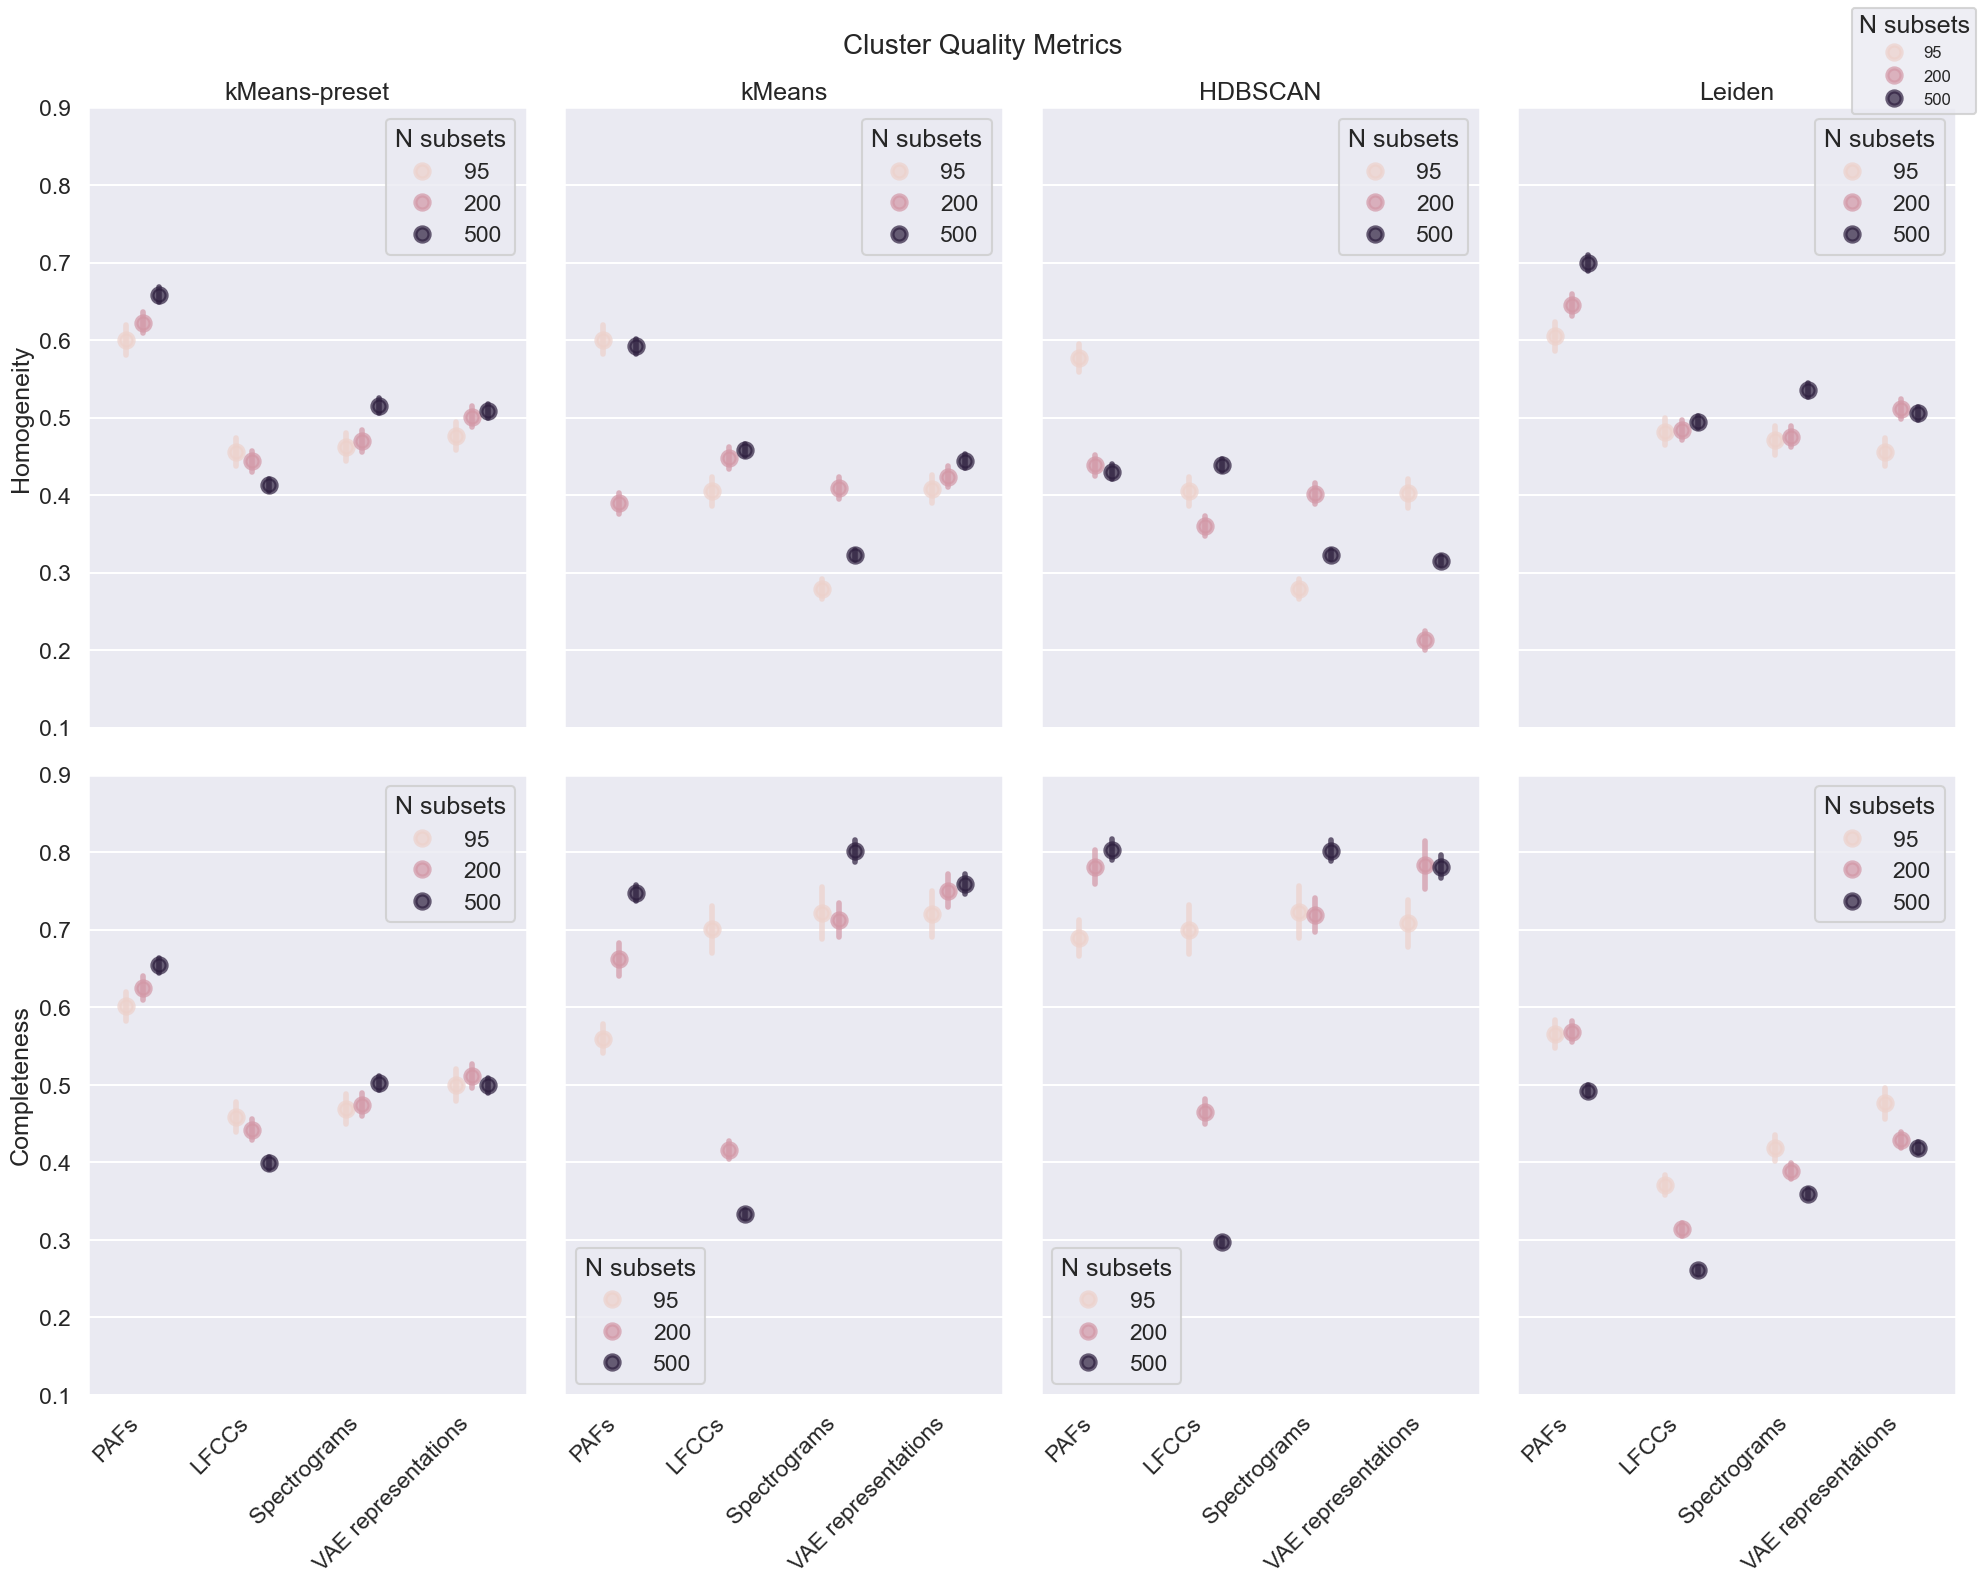

In [15]:
true_vs_pred_df_exploded_filtered = true_vs_pred_df_exploded[
    (true_vs_pred_df_exploded["Alarm call subset"] == "yes") &
    (true_vs_pred_df_exploded["Distance metric"] == "l2")
]

columns = ["kMeans-preset", "kMeans", "HDBSCAN", "Leiden"]
representations = ['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations']
rows = ["Homogeneity", "Completeness"]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 16), sharex=True, sharey=True)


for row, metric in enumerate(rows):
    for col, column in enumerate(columns):
        sns.pointplot(
            x="Representation", 
            y=metric,  
            data=true_vs_pred_df_exploded_filtered[true_vs_pred_df_exploded_filtered["Algorithm"] == column], 
            ax=axs[row, col], 
            hue="N subsets", 
            linestyle="none",
            alpha=.7,
            errorbar="sd",
            dodge=.3,
        )

        if row == 0:
            axs[row, col].set_title(column)

        axs[row, col].set_ylim(0.1, 0.9)
        axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
        axs[row, col].set_xlabel('')

        if col == 0:
            axs[row, col].set_ylabel(metric)  # Label only the first column
        else:
            axs[row, col].set_ylabel('')

handles, labels = axs[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, title="N subsets", loc="upper right", fontsize=12)

fig.suptitle("Cluster Quality Metrics", fontsize=20)
plt.tight_layout()
plt.show()


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_48175/3723686770.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_48175/3723686770.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_48175/3723686770.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_48175/3723686770.py:31: UserWarning: set_ticklabels() should only be used with a fixed

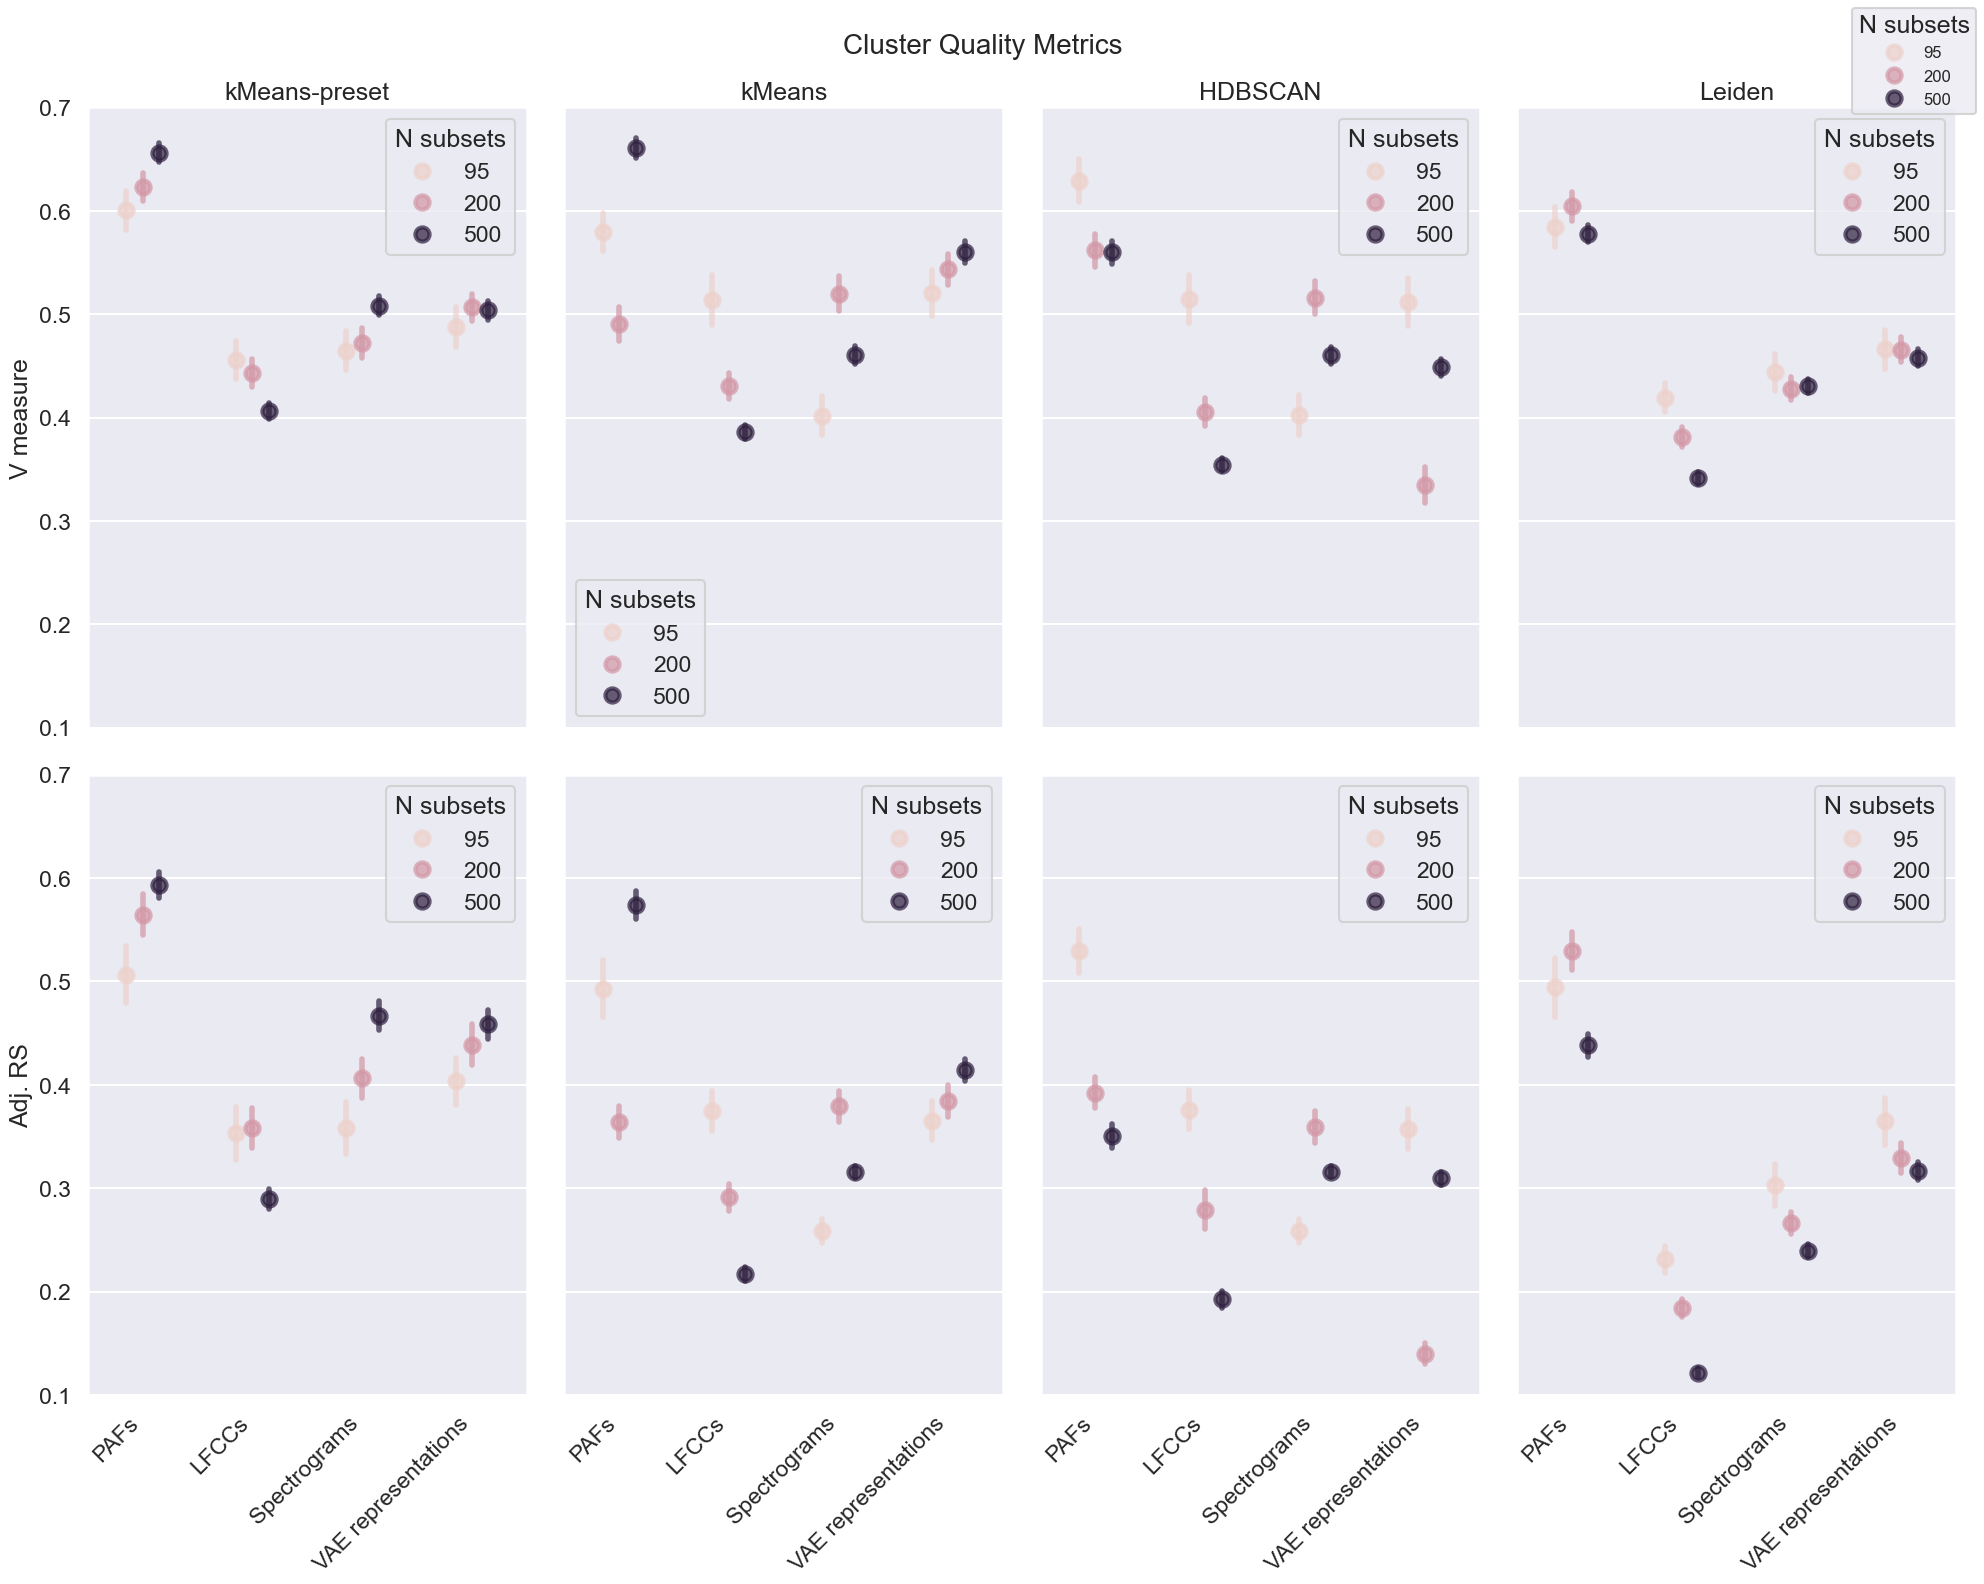

In [ ]:
columns = ["kMeans-preset", "kMeans", "HDBSCAN", "Leiden"]
representations = ['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations']
rows = ["V measure", "Adj. RS"]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 16), sharex=True, sharey=True)


for row, metric in enumerate(rows):
    for col, column in enumerate(columns):
        sns.pointplot(
            x="Representation", 
            y=metric,  
            data=true_vs_pred_df_exploded_filtered[true_vs_pred_df_exploded_filtered["Algorithm"] == column], 
            ax=axs[row, col], 
            hue="N subsets", 
            linestyle="none",
            alpha=.7,
            errorbar="sd",
            dodge=.3,
        )

        if row == 0:
            axs[row, col].set_title(column)

        axs[row, col].set_ylim(0.1, 0.7)
        axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
        axs[row, col].set_xlabel('')

        if col == 0:
            axs[row, col].set_ylabel(metric)  # Label only the first column
        else:
            axs[row, col].set_ylabel('')

handles, labels = axs[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, title="N subsets", loc="upper right", fontsize=12)

fig.suptitle("Cluster Quality Metrics", fontsize=20)
plt.tight_layout()
plt.show()


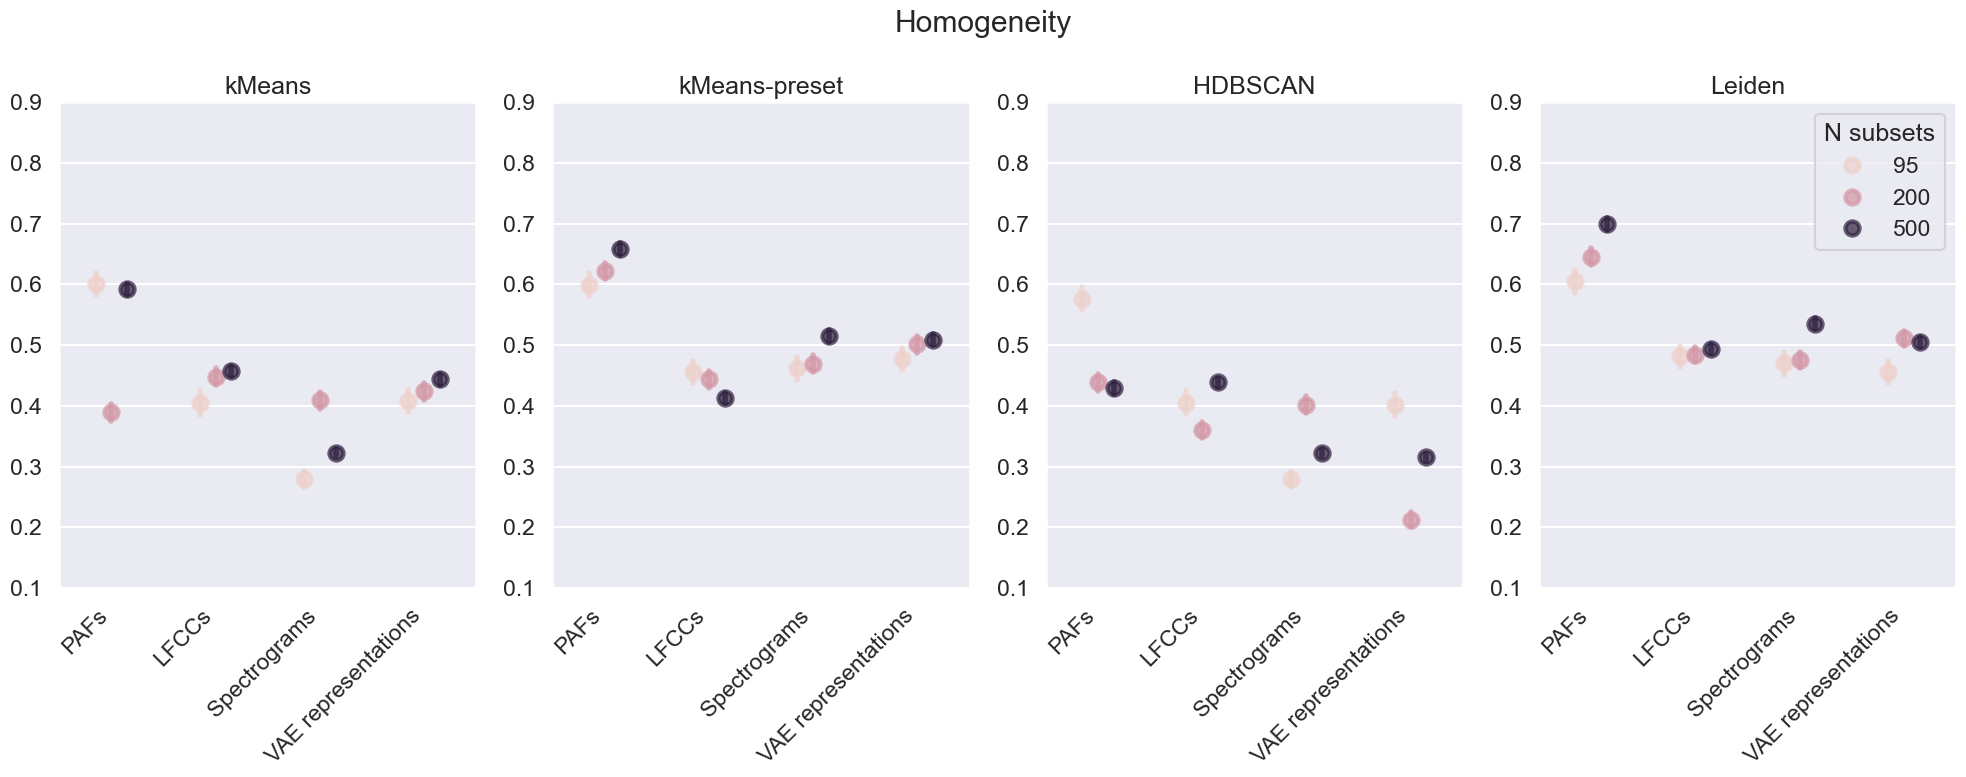

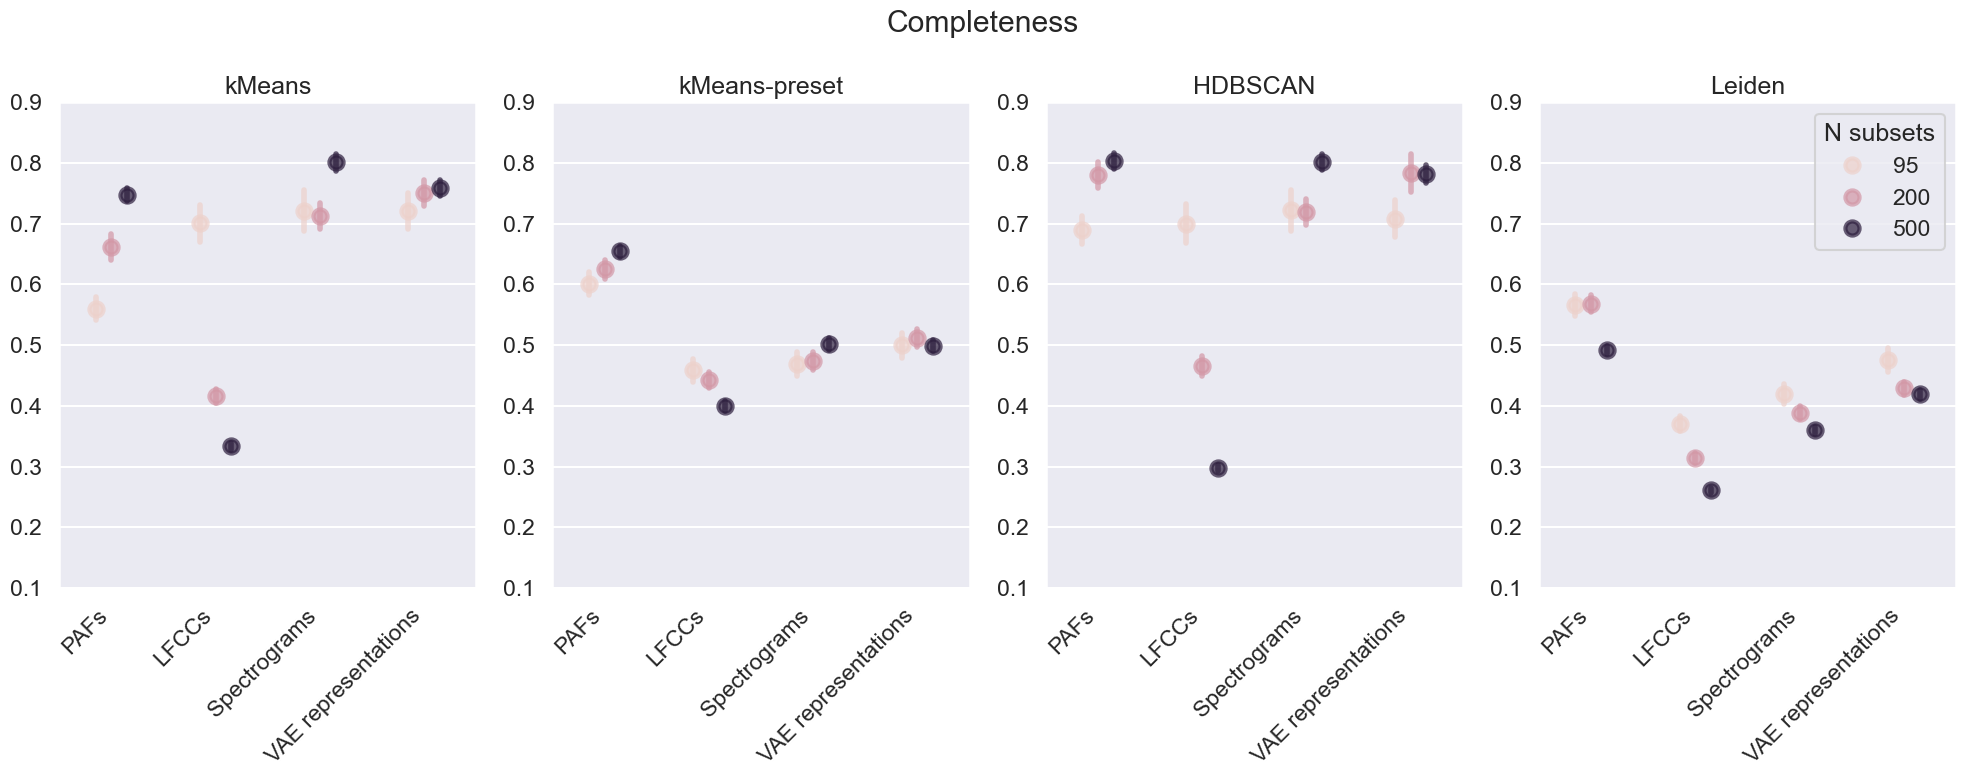

In [20]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 8))

columns = ["kMeans", "kMeans-preset", "HDBSCAN", "Leiden"]
for i, column in enumerate(columns):
    sns.pointplot(
        x="Representation", 
        y="Homogeneity", 
        data=true_vs_pred_df_exploded_filtered[true_vs_pred_df_exploded_filtered["Algorithm"]==column], 
        ax=axs[i], 
        hue="N subsets", 
        legend=(True if i == len(columns)-1 else False),
        linestyle="none",
        alpha=.7,
        errorbar="sd",
        dodge=.3,
    )

    axs[i].set_ylim(.1,.9)
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

fig.suptitle("Homogeneity")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(ncols=4, figsize=(20, 8))

columns = ["kMeans", "kMeans-preset", "HDBSCAN", "Leiden"]
for i, column in enumerate(columns):
    sns.pointplot(
        x="Representation", 
        y="Completeness", 
        data=true_vs_pred_df_exploded_filtered[true_vs_pred_df_exploded_filtered["Algorithm"]==column], 
        ax=axs[i], 
        hue="N subsets", 
        legend=(True if i == len(columns)-1 else False),
        linestyle="none",
        alpha=.7,
        errorbar="sd",
        dodge=.3,
    )

    axs[i].set_ylim(.1,.9)
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

fig.suptitle("Completeness")
plt.tight_layout()
plt.show()

In [21]:
rows = []
for di in dicts:
    for representation in representation_keys:
        for algorithm in algorithm_keys:
            v_measure, st_err, ci_low, ci_high, p_value, chance_level, _ = stats.v_measure_against_chance(
                di["true_labels"], 
                di[representation][algorithm],  
                plot=False)
            
            rows.append([
                di["n"], 
                di["distance_metric"], 
                di["alarm"],
                representation,
                algorithm,
                v_measure,
                st_err,
                ci_low,
                ci_high,
                p_value,
                chance_level, 
                homogeneity_score(di["true_labels"], di[representation][algorithm]),
                completeness_score(di["true_labels"], di[representation][algorithm]),
                adjusted_rand_score(di["true_labels"], di[representation][algorithm])
            ])

true_vs_pred_df_single_rows = pd.DataFrame(
    rows, 
    columns=["N subsets", "Distance metric", "Alarm call subset", "Representation", "Algorithm", "V measure", "st_err", "ci_low", "ci_high", "p-value", "Chance level", "Homogeneity", "Completeness", "Adj. RS"]
)

print(true_vs_pred_df_single_rows)

    N subsets Distance metric Alarm call subset       Representation  \
0          95              l2               yes                 PAFs   
1          95              l2               yes                 PAFs   
2          95              l2               yes                 PAFs   
3          95              l2               yes                 PAFs   
4          95              l2               yes                LFCCs   
..        ...             ...               ...                  ...   
75        500              l2                no         Spectrograms   
76        500              l2                no  VAE representations   
77        500              l2                no  VAE representations   
78        500              l2                no  VAE representations   
79        500              l2                no  VAE representations   

        Algorithm  V measure    st_err    ci_low   ci_high  p-value  \
0          kMeans   0.579164  0.018643  0.533250  0.597924      

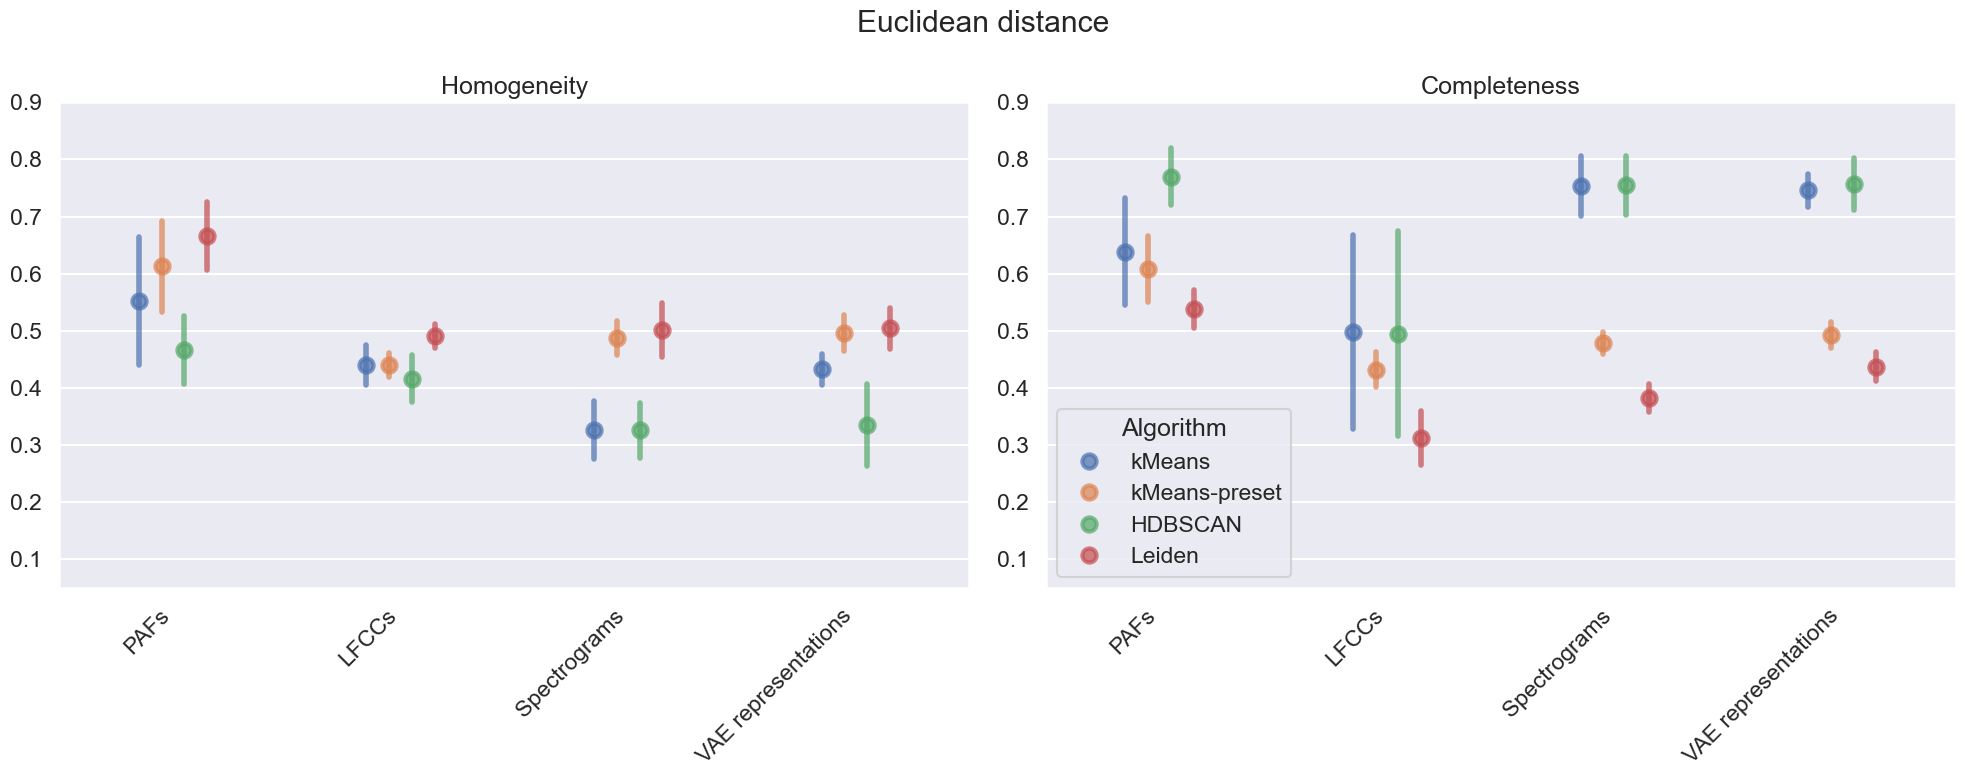

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["Homogeneity", "Completeness"]
for i, column in enumerate(columns):
    # Raw datapoints
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_exploded, 
        ax=axs[i], 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False),
        linestyle="none",
        alpha=.7,
        errorbar="sd",
        dodge=.3,
    )
    
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.05, .9)

fig.suptitle("Euclidean distance")
plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

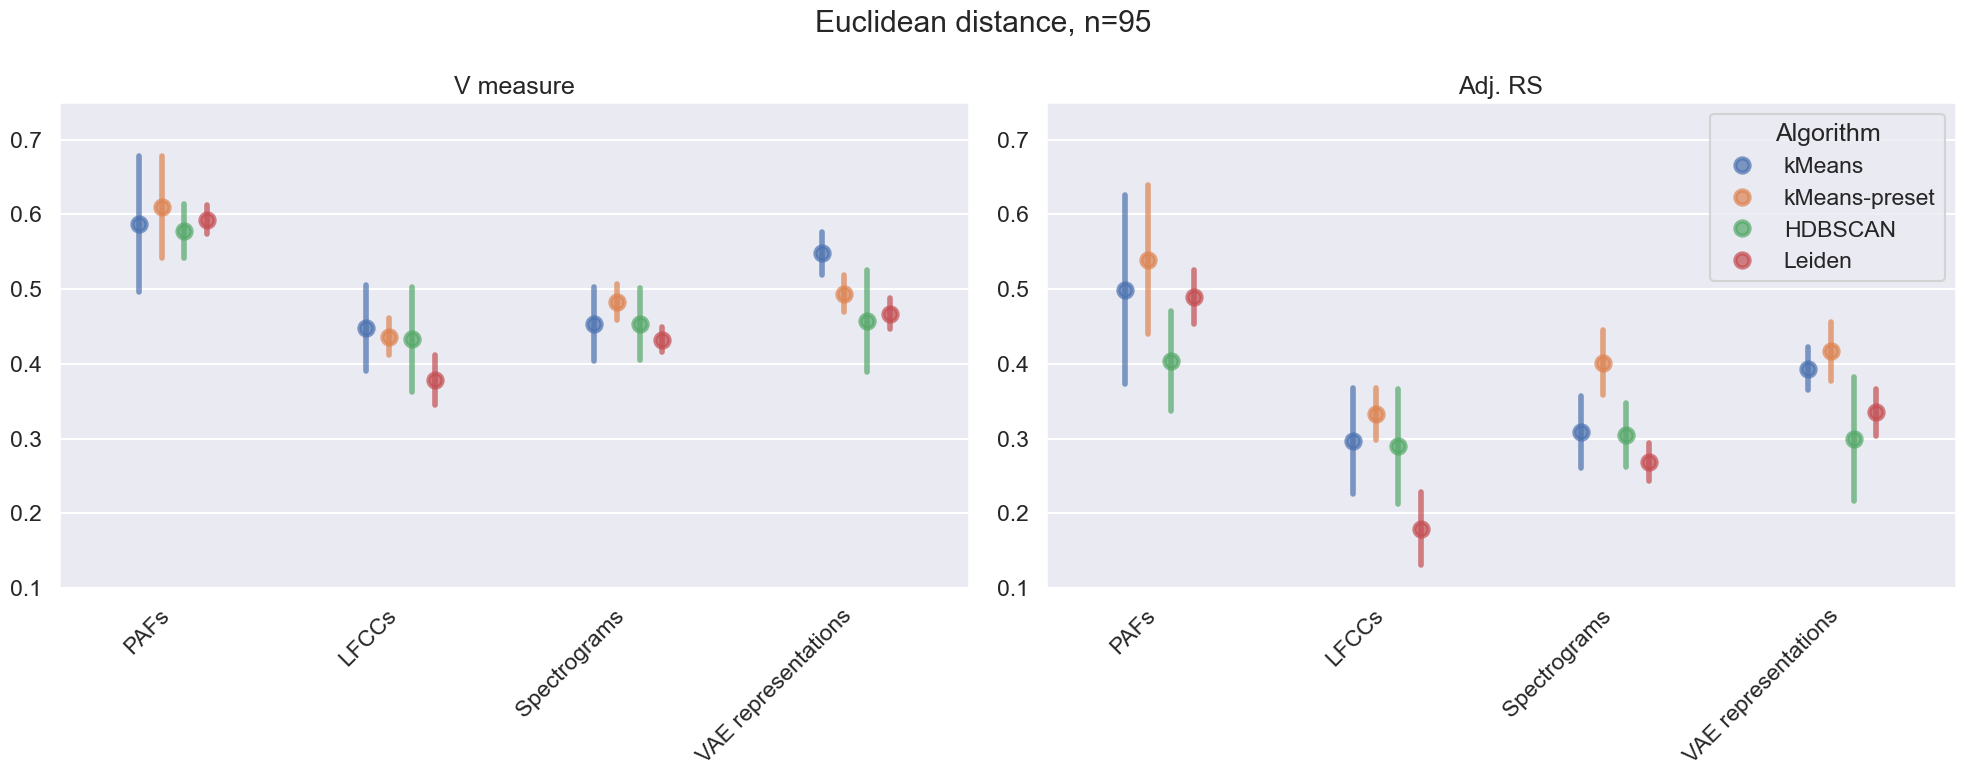

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["V measure", "Adj. RS"]
for i, column in enumerate(columns):
    # Raw datapoints
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_exploded, 
        ax=axs[i], 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False),
        linestyle="none",
        alpha=.7,
        errorbar="sd",
        dodge=.3,
    )
    
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.1, .75)

fig.suptitle("Euclidean distance, n=95")
plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

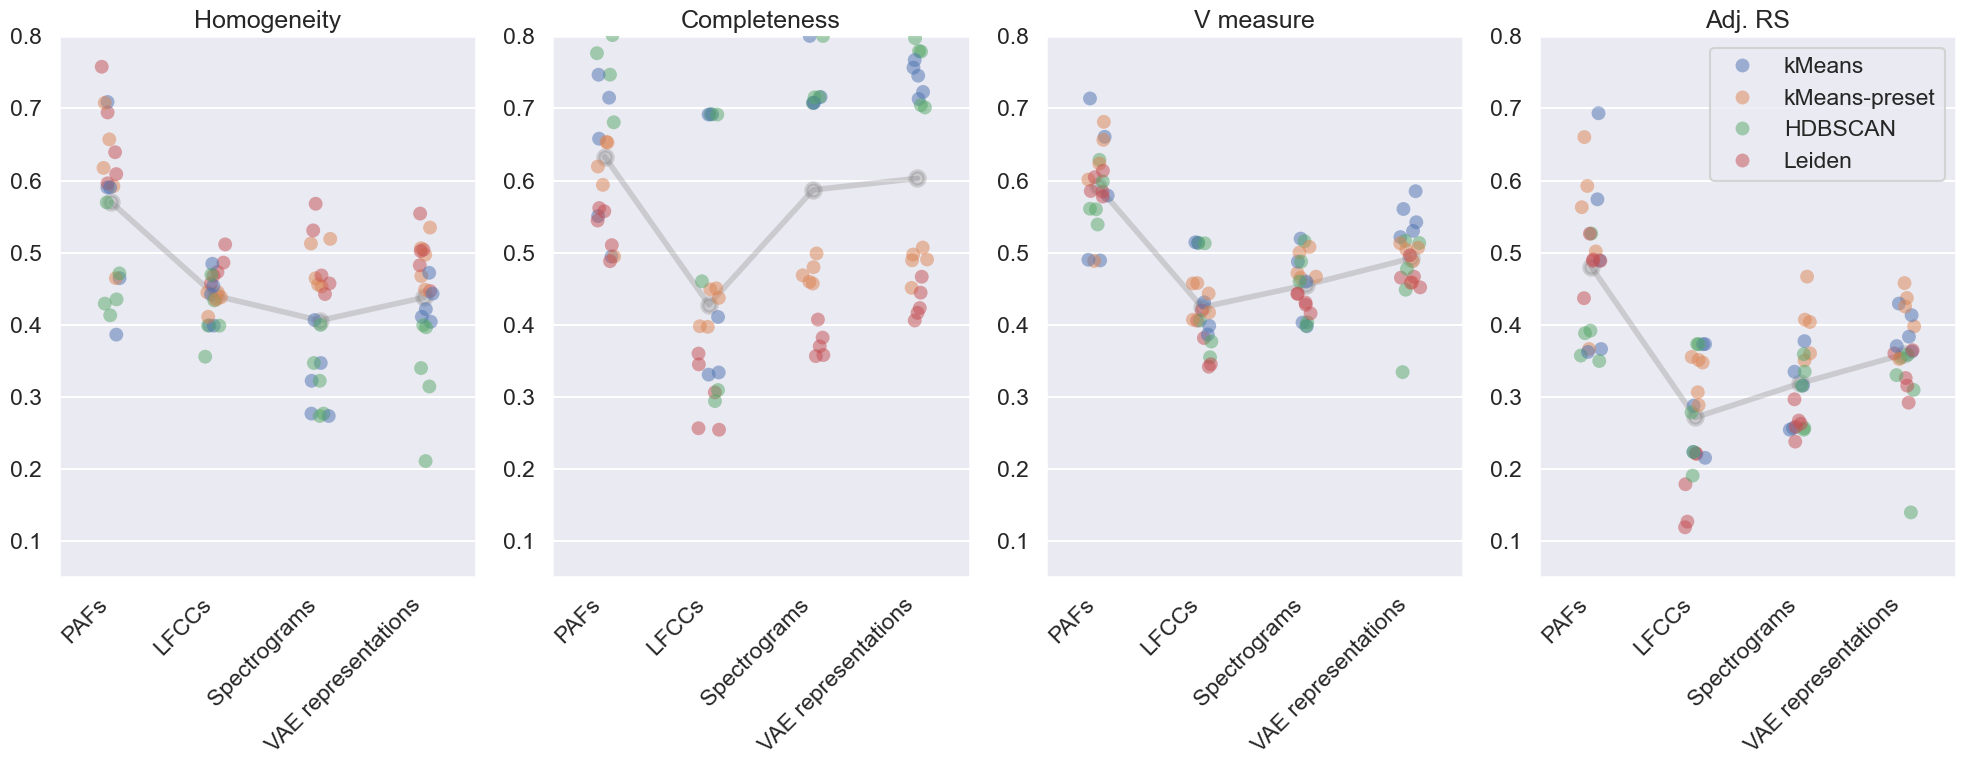

In [24]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 8))

columns = ["Homogeneity", "Completeness", "V measure", "Adj. RS"]
for i, column in enumerate(columns):
    # Raw data points
    sns.stripplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_single_rows, 
        ax=axs[i], 
        jitter=True, 
        size=10, 
        hue="Algorithm", 
        alpha=0.5, 
        legend=(True if i == len(columns)-1 else False)
    )
    
    # Mean points
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_single_rows, 
        ax=axs[i], 
        errorbar=None,
        markers="o", 
        color="grey",
        alpha=.3
    )

    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.05, 0.8)

plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

In [25]:
# Generate LaTeX Table
latex_table = true_vs_pred_df.to_latex(
    index=True,
    multirow=True,
    caption="Clustering Metrics for Representations",
    label="tab:clustering_metrics",
    na_rep="---",
)

print(latex_table)

\begin{table}
\caption{Clustering Metrics for Representations}
\label{tab:clustering_metrics}
\begin{tabular}{lrllllrrllll}
\toprule
 & N subsets & Distance metric & Alarm call subset & Representation & Algorithm & p-value & Chance level & V measure & Homogeneity & Completeness & Adj. RS \\
\midrule
0 & 95 & l2 & yes & PAFs & kMeans & 0.000000 & 0.014318 & [0.56378746 0.56596571 0.56297203 0.57150732 0.57749498 0.57856191
 0.58712757 0.56797095 0.57694546 0.57410693 0.56588071 0.57917108
 0.60602717 0.55694227 0.58114919 0.59760816 0.60155497 0.5856528
 0.57734371 0.56846809 0.60935914 0.55119425 0.57408766 0.59422671
 0.58179257 0.59709786 0.55013192 0.61074037 0.55532476 0.56519397
 0.58892078 0.58080946 0.58368291 0.60631973 0.52890706 0.59212388
 0.57324512 0.57256339 0.59169807 0.5826167  0.58550061 0.57691895
 0.56957838 0.59354535 0.58723336 0.56692371 0.57273266 0.55004629
 0.62204373 0.58214867 0.57385475 0.55457451 0.59412362 0.56790684
 0.56996463 0.5821252  0.60999064 0.596

#### Compare algorithms

In [35]:
true_vs_pred_df.head()

N subsets Distance metric Alarm call subset Representation      Algorithm  \
0         95              l2               yes           PAFs         kMeans   
1         95              l2               yes           PAFs  kMeans-preset   
2         95              l2               yes           PAFs        HDBSCAN   
3         95              l2               yes           PAFs         Leiden   
4         95              l2               yes          LFCCs         kMeans   

   p-value  Chance level                                          V measure  \
0      0.0      0.014318  [0.5637874585789181, 0.5659657148192363, 0.562...   
1      0.0      0.012444  [0.5873447057580722, 0.56343306511813, 0.61776...   
2      0.0      0.010865  [0.6079543462849489, 0.6283900267612448, 0.640...   
3      0.0      0.014499  [0.6340392776119668, 0.5836388708311936, 0.562...   
4      0.0      0.006331  [0.5160885698446015, 0.5278271827659385, 0.519...   

                                         Homogeneity  \
0  [0.6203824769401097, 0.608493042352808, 0.5978...   
1  [0.5983903479771799, 0.5712477237372181, 0.600...   
2  [0.5878154737249611, 0.5939162676381036, 0.603...   
3  [0.5668869334164446, 0.6010641907977141, 0.566...   
4  [0.3951277021371481, 0.39111270179679203, 0.39...   

                                        Completeness  \
0  [0.525981692751267, 0.5437469279002386, 0.5549...   
1  [0.5672039634191266, 0.5749930674425529, 0.597...   
2  [0.6734738788800139, 0.6561833370466068, 0.656...   
3  [0.5466253982923609, 0.5540588462472607, 0.546...   
4  [0.6643903911744565, 0.7104912596529606, 0.751...   

                                             Adj. RS  
0  [0.49876969772767155, 0.4965093949192132, 0.53...  
1  [0.49454771003597475, 0.5245683281732693, 0.53...  
2  [0.5377883242964782, 0.5850877466892864, 0.535...  
3  [0.4812415101314971, 0.48652985007299737, 0.55...  
4  [0.38291884333398096, 0.38648437452946927, 0.3...

In [ ]:
rows = []
for n in (95, 200, 500):
    for representation in representation_keys:
        for algorithm_a, algorithm_b in itertools.combinations(algorithm_keys, 2):
            df_a = true_vs_pred_df[
                (true_vs_pred_df["N subsets"] == n) &
                (true_vs_pred_df["Distance metric"] == "l2") &
                (true_vs_pred_df["Alarm call subset"] == "yes") &
                (true_vs_pred_df["Representation"] == representation) &
                (true_vs_pred_df["Algorithm"] == algorithm_a)
            ]

            df_b = true_vs_pred_df[
                (true_vs_pred_df["N subsets"] == n) &
                (true_vs_pred_df["Distance metric"] == "l2") &
                (true_vs_pred_df["Alarm call subset"] == "yes") &
                (true_vs_pred_df["Representation"] == representation) &
                (true_vs_pred_df["Algorithm"] == algorithm_b)
            ]

            if len(df_a["Adj. RS"].values[0]) == len(df_b["Adj. RS"].values[0]) and len(df_b["Adj. RS"].values[0]) > 1:
                rand_res = ttest_rel(df_a["Adj. RS"].values[0], df_b["Adj. RS"].values[0])
                V_res = ttest_rel(df_a["V measure"].values[0], df_b["V measure"].values[0])

                # Append results
                rows.append([
                    n, "l2", "yes", representation, algorithm_a, algorithm_b,
                    rand_res.statistic, rand_res.pvalue,
                    V_res.statistic, V_res.pvalue
                ])

# Convert to DataFrame
match_scores_across_results = pd.DataFrame(
    rows, 
    columns=["N subsets", "Distance metric", "Alarm call subset", "Representation", "Algorithm A", "Algorithm B", 
             "Adjusted Rand Score", "Adjusted Rand Score - p-value",
             "V Measure Score", "V Measure Score - p-value"]
)

match_scores_across_results

N subsets Distance metric Alarm call subset       Representation  \
0          95              l2               yes                 PAFs   
1          95              l2               yes                 PAFs   
2          95              l2               yes                 PAFs   
3          95              l2               yes                 PAFs   
4          95              l2               yes                 PAFs   
..        ...             ...               ...                  ...   
67        500              l2               yes  VAE representations   
68        500              l2               yes  VAE representations   
69        500              l2               yes  VAE representations   
70        500              l2               yes  VAE representations   
71        500              l2               yes  VAE representations   

      Algorithm A    Algorithm B  Adjusted Rand Score  \
0          kMeans  kMeans-preset           -10.475060   
1          kMeans        HDBSCAN           -32.304749   
2          kMeans         Leiden            -0.933385   
3   kMeans-preset        HDBSCAN           -20.973547   
4   kMeans-preset         Leiden             9.703859   
..            ...            ...                  ...   
67         kMeans        HDBSCAN           275.609093   
68         kMeans         Leiden           229.671787   
69  kMeans-preset        HDBSCAN           314.351667   
70  kMeans-preset         Leiden           260.900371   
71        HDBSCAN         Leiden           -20.442017   

    Adjusted Rand Score - p-value  V Measure Score  V Measure Score - p-value  
0                    1.965735e-24       -25.339349              8.520197e-110  
1                   2.478508e-157       -56.272250              5.214802e-312  
2                    3.508468e-01        -6.175794               9.564661e-10  
3                    3.210994e-81       -33.321352              2.603610e-164  
4                    2.451480e-21        18.161619               6.470859e-64  
..                            ...              ...                        ...  
67                   0.000000e+00       248.059145               0.000000e+00  
68                   0.000000e+00       247.068839               0.000000e+00  
69                   0.000000e+00       139.462828               0.000000e+00  
70                   0.000000e+00       119.349920               0.000000e+00  
71                   7.225316e-78       -25.188564              8.739387e-109  

[72 rows x 10 columns]

In [85]:
print(true_vs_pred_df_exploded['Representation'].unique())

['PAFs' 'LFCCs' 'Spectrograms' 'VAE representations']


ZeroDivisionError: float division by zero

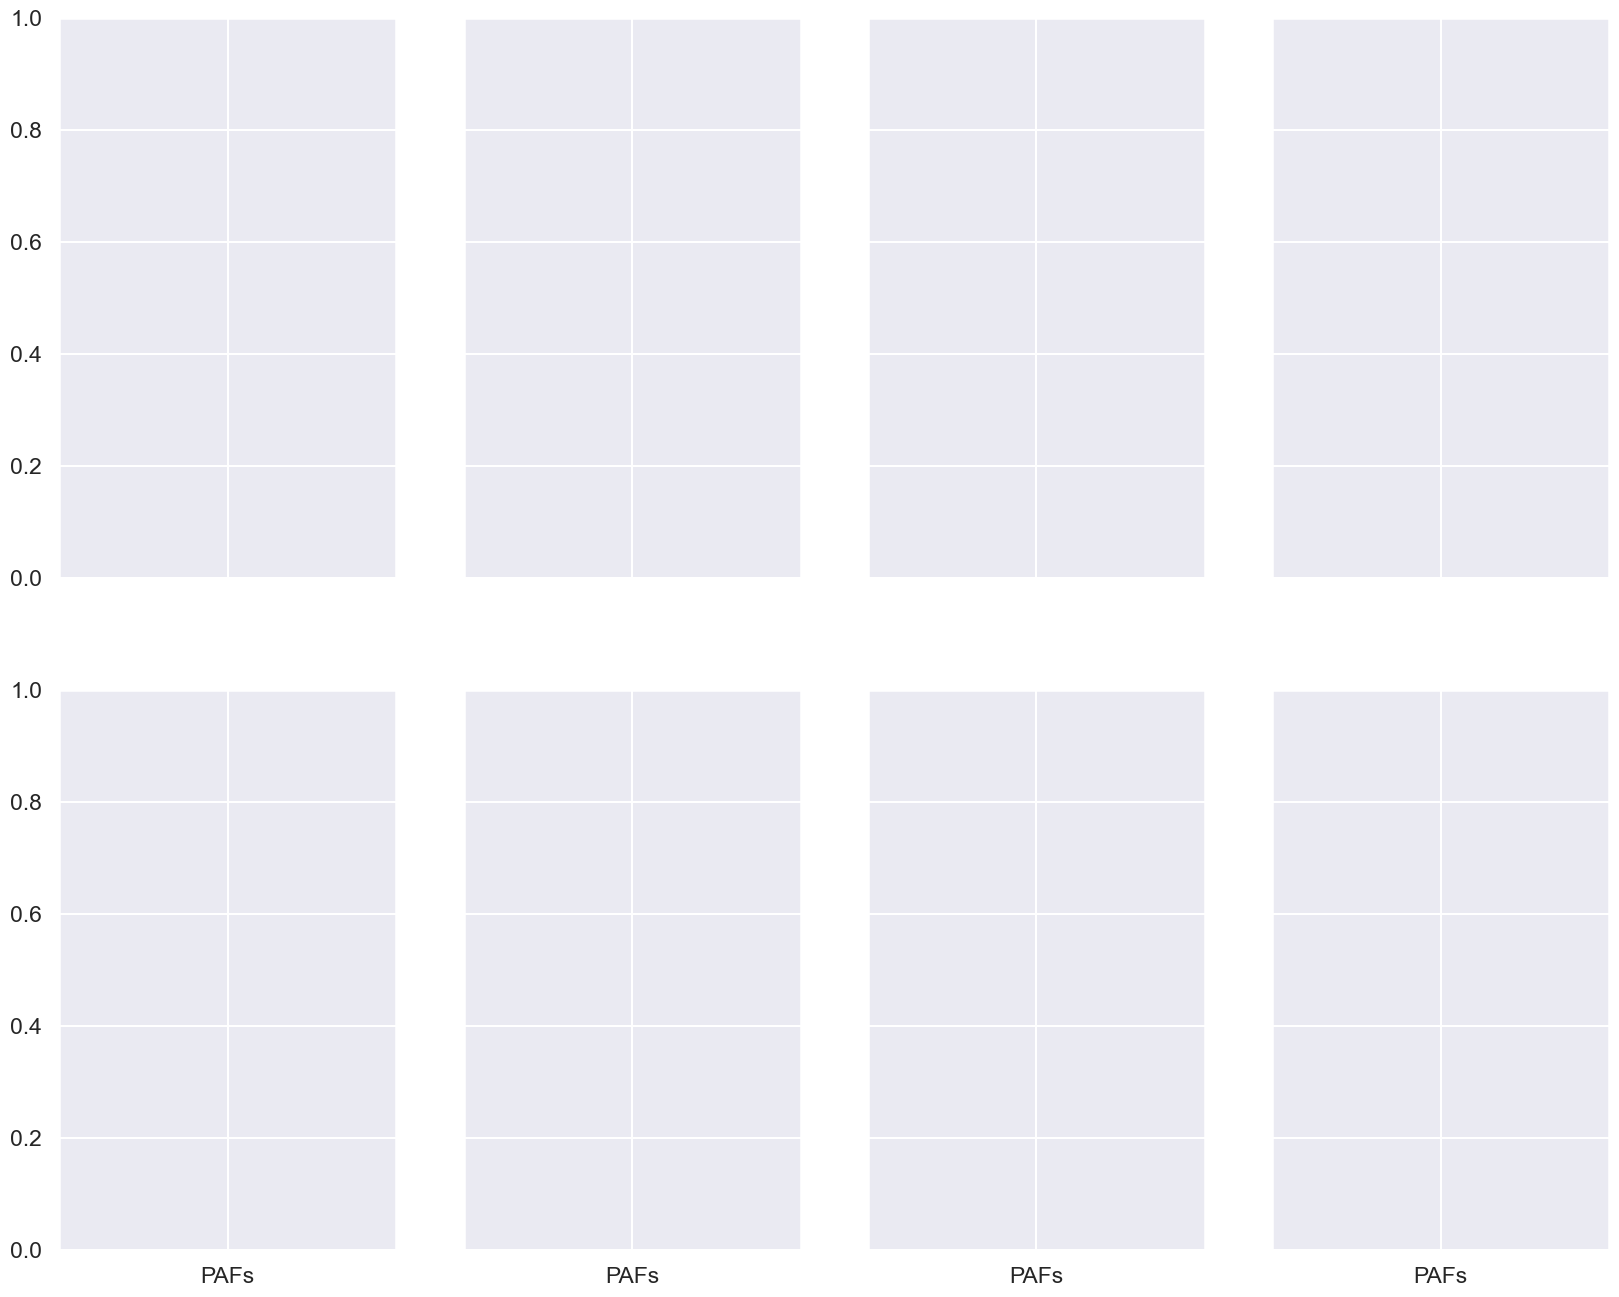

In [118]:
from statannotations.Annotator import Annotator

columns = ["kMeans-preset", "kMeans", "HDBSCAN", "Leiden"]
representations = ['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations']
rows = ["V measure", "Adj. RS"]
pairs=[("PAFs", "LFCCs"), ("PAFs", "Spectrograms"), ("PAFs", "VAE representations"), ("LFCCs", "Spectrograms"), ("LFCCs", "VAE representations"), ("Spectrograms", "VAE representations")]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 16), sharex=True, sharey=True)
for row, metric in enumerate(rows):
    for col, column in enumerate(columns):
        sns.pointplot(
            x="Representation", 
            y=metric,  
            data=true_vs_pred_df_exploded_filtered[(true_vs_pred_df_exploded_filtered["Algorithm"] == column) & (true_vs_pred_df_exploded_filtered["N subsets"] == 95) ], 
            ax=axs[row, col], 
            hue="N subsets", 
            linestyle="none",
            alpha=.7,
            errorbar="sd",
            dodge=.3,
        )
        annotator = Annotator(axs[row, col], data=true_vs_pred_df_exploded_filtered[(true_vs_pred_df_exploded_filtered["Algorithm"] == column) & (true_vs_pred_df_exploded_filtered["N subsets"] == 95) ], x="Representation", y=row, pairs=pairs)
        annotator.configure(test='t-test_paired', text_format='star', loc='outside')
        annotator.apply_and_annotate()

        if row == 0:
            axs[row, col].set_title(column)

        axs[row, col].set_ylim(0.1, 0.7)
        axs[row, col].set_xticklabels(representations, rotation=45, ha='right')
        axs[row, col].set_xlabel(column)

        if col == 0:
            axs[row, col].set_ylabel(metric)  # Label only the first column
        else:
            axs[row, col].set_ylabel('')

handles, labels = axs[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, title="N subsets", loc="upper right", fontsize=12)

fig.suptitle("Cluster Quality Metrics", fontsize=20)
plt.tight_layout()
plt.show()


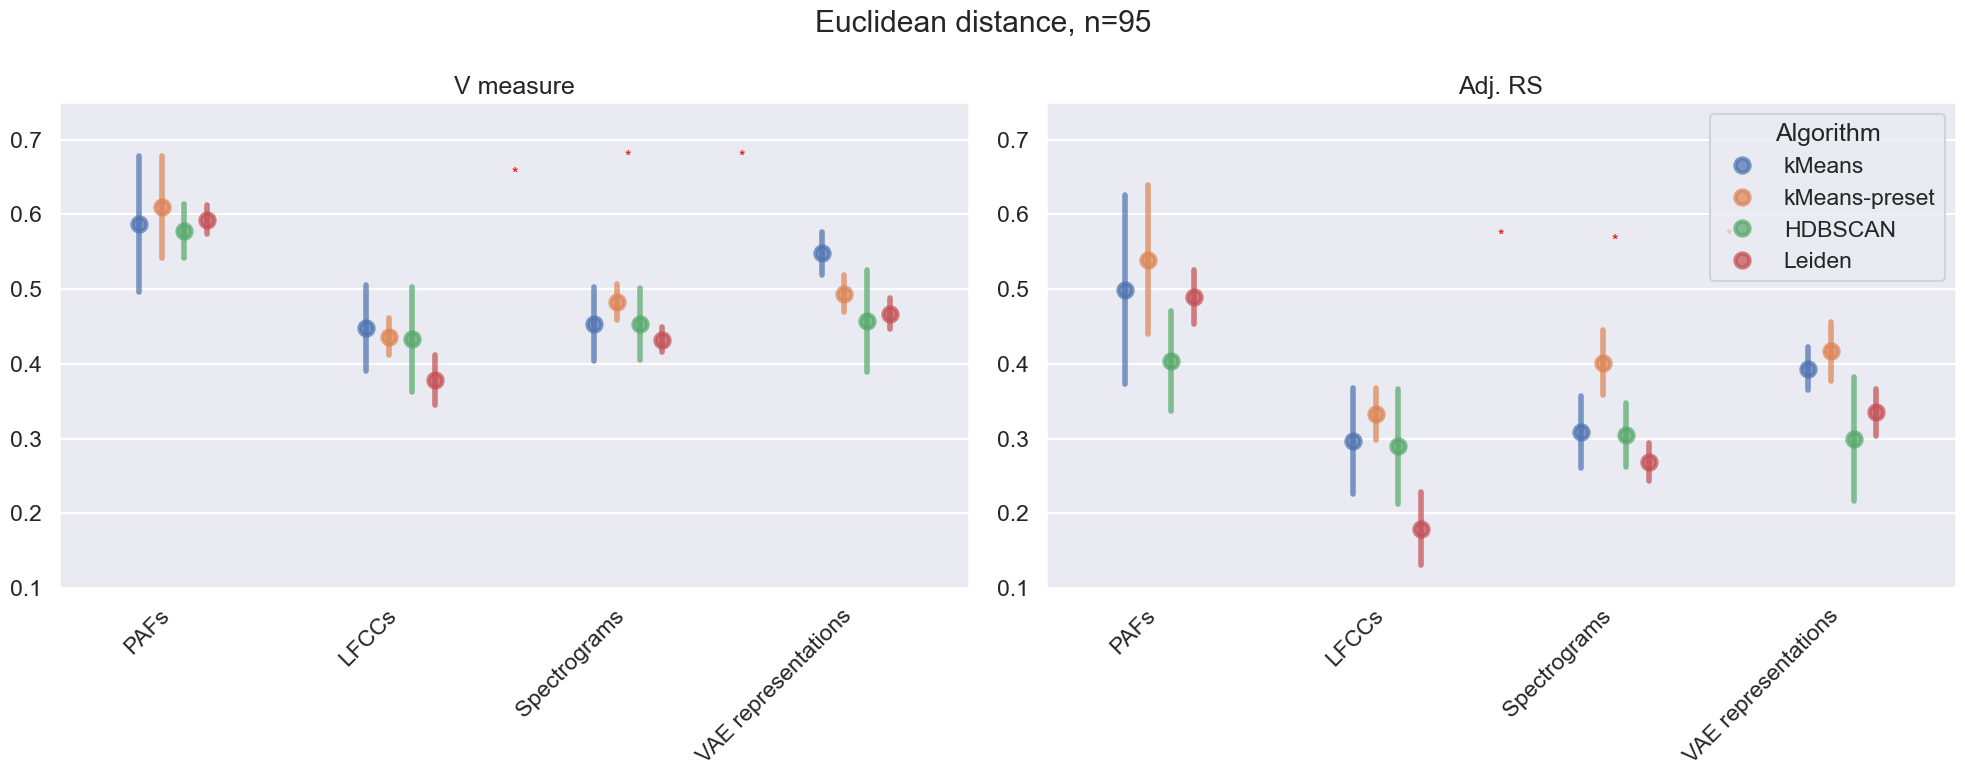

In [79]:
# Assuming 'true_vs_pred_df_exploded' is already your dataframe
# Let's calculate the p-values and create a function to add asterisks
def add_significance(ax, data, x, y, significance_level=0.05):
    representations = ['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations']
    
    # Loop over the representations to compare them
    for i, rep1 in enumerate(representations):
        for j, rep2 in enumerate(representations):
            if i >= j:
                continue
            
            # Get the data for the two representations
            group1 = data[data[x] == rep1][y]
            group2 = data[data[x] == rep2][y]
            
            # Perform t-test (or any other pairwise test)
            t_stat, p_value = ttest_rel(group1, group2)
            
            # If the p-value is below the significance level, add an asterisk
            if p_value < significance_level:
                # Annotate with asterisk at the mean y-value between the groups
                ax.annotate('*', 
                            xy=((i+j)/2, max(group1.max(), group2.max()) + 0.05),
                            ha='center', va='bottom', color='red', fontsize=12)

# Now create your plot using the dataframe directly
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["V measure", "Adj. RS"]
for i, column in enumerate(columns):
    # Raw datapoints
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_exploded, 
        ax=axs[i], 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False),
        linestyle="none",
        alpha=.7,
        errorbar="sd",
        dodge=.3,
    )
    
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.1, .75)

    # Add significance asterisks directly from the dataframe
    add_significance(axs[i], true_vs_pred_df_exploded, 'Representation', column)

fig.suptitle("Euclidean distance, n=95")
plt.tight_layout()
plt.show()


In [73]:
# Create LaTeX table with bold p-values for significance
latex_table = "\\begin{table}[ht]\n"
latex_table += "\\centering\n"
latex_table += "\\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}\n"
latex_table += "\\hline\n"
latex_table += "N subsets & Distance metric & Alarm call subset & Representation & Algorithm A & Algorithm B & Adjusted Rand Score & \\textbf{Adjusted Rand Score p-value} & V Measure Score & \\textbf{V Measure Score p-value} \\\\ \n"
latex_table += "\\hline\n"

# Loop through the results and create the table rows
for idx, row in match_scores_across_results.iterrows():
    adj_rs_pvalue = row["Adjusted Rand Score - p-value"]
    v_measure_pvalue = row["V Measure Score - p-value"]
    
    # Bold p-value if significant
    adj_rs_pvalue_str = f"\\textbf{{{adj_rs_pvalue:.3f}}}" if adj_rs_pvalue < 0.05 else f"{adj_rs_pvalue:.3f}"
    v_measure_pvalue_str = f"\\textbf{{{v_measure_pvalue:.3f}}}" if v_measure_pvalue < 0.05 else f"{v_measure_pvalue:.3f}"
    
    latex_table += f"{row['N subsets']} & {row['Distance metric']} & {row['Alarm call subset']} & {row['Representation']} & {row['Algorithm A']} & {row['Algorithm B']} & {row['Adjusted Rand Score']:.3f} & {adj_rs_pvalue_str} & {row['V Measure Score']:.3f} & {v_measure_pvalue_str} \\\\ \n"
    latex_table += "\\hline\n"

latex_table += "\\end{tabular}\n"
latex_table += "\\caption{Statistical Comparison between Algorithm Pairs}\n"
latex_table += "\\end{table}"

# Output the LaTeX code
print(latex_table)


\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\hline
N subsets & Distance metric & Alarm call subset & Representation & Algorithm A & Algorithm B & Adjusted Rand Score & \textbf{Adjusted Rand Score p-value} & V Measure Score & \textbf{V Measure Score p-value} \\ 
\hline
95 & l2 & yes & PAFs & kMeans & kMeans-preset & -10.475 & \textbf{0.000} & -25.339 & \textbf{0.000} \\ 
\hline
95 & l2 & yes & PAFs & kMeans & HDBSCAN & -32.305 & \textbf{0.000} & -56.272 & \textbf{0.000} \\ 
\hline
95 & l2 & yes & PAFs & kMeans & Leiden & -0.933 & 0.351 & -6.176 & \textbf{0.000} \\ 
\hline
95 & l2 & yes & PAFs & kMeans-preset & HDBSCAN & -20.974 & \textbf{0.000} & -33.321 & \textbf{0.000} \\ 
\hline
95 & l2 & yes & PAFs & kMeans-preset & Leiden & 9.704 & \textbf{0.000} & 18.162 & \textbf{0.000} \\ 
\hline
95 & l2 & yes & PAFs & HDBSCAN & Leiden & 31.163 & \textbf{0.000} & 49.505 & \textbf{0.000} \\ 
\hline
95 & l2 & yes & LFCCs & kMeans & kMeans-preset & 21.296 & \textbf{0.000} & 

In [67]:
algorithm_keys_wo_leiden = ["kMeans", "kMeans-preset", "HDBSCAN"]
rows = []
for di in dicts:
    for representation in representation_keys:
        for algorithm_a, algorithm_b in itertools.product(algorithm_keys_wo_leiden, algorithm_keys_wo_leiden):
            if algorithm_a == algorithm_b:
                continue
            krusk_res = stats.silhouette_across_embeddings(di[representation][algorithm_a], di[representation][algorithm_b], di[representation]["embeddings"])
            rows.append([
                di["n"], 
                di["distance_metric"], 
                di["alarm"],
                representation, 
                algorithm_a, 
                algorithm_b,
                krusk_res.statistic, 
                krusk_res.pvalue,
                ])

silhouette_scores_across_results = pd.DataFrame(
    rows, 
    columns=["N subsets", "Distance metric", "Alarm call subset", "Representation", "Algorithm a", "Algorithm b", 
             "Silhouette score - Kruskal statistic", "Silhouette score - Kruskal p-value",]
)

silhouette_scores_across_results

N subsets Distance metric Alarm call subset       Representation  \
0           95              l2               yes                 PAFs   
1           95              l2               yes                 PAFs   
2           95              l2               yes                 PAFs   
3           95              l2               yes                 PAFs   
4           95              l2               yes                 PAFs   
..         ...             ...               ...                  ...   
115        500              l2                no  VAE representations   
116        500              l2                no  VAE representations   
117        500              l2                no  VAE representations   
118        500              l2                no  VAE representations   
119        500              l2                no  VAE representations   

       Algorithm a    Algorithm b  Silhouette score - Kruskal statistic  \
0           kMeans  kMeans-preset                              0.861517   
1           kMeans        HDBSCAN                             15.838977   
2    kMeans-preset         kMeans                              0.861517   
3    kMeans-preset        HDBSCAN                             16.577256   
4          HDBSCAN         kMeans                             15.838977   
..             ...            ...                                   ...   
115         kMeans        HDBSCAN                              0.085212   
116  kMeans-preset         kMeans                           2621.646610   
117  kMeans-preset        HDBSCAN                           2260.734439   
118        HDBSCAN         kMeans                              0.085212   
119        HDBSCAN  kMeans-preset                           2260.734439   

     Silhouette score - Kruskal p-value  
0                              0.353315  
1                              0.000069  
2                              0.353315  
3                              0.000047  
4                              0.000069  
..                                  ...  
115                            0.770355  
116                            0.000000  
117                            0.000000  
118                            0.770355  
119                            0.000000  

[120 rows x 8 columns]

In [54]:
# Generate LaTeX Table
latex_table_2 = silhouette_scores_across_results.to_latex(
    index=True,
    multirow=True,
    caption="Clustering Metrics for Representations",
    label="tab:clustering_metrics",
    na_rep="---",
)

print(latex_table_2)

\begin{table}
\caption{Clustering Metrics for Representations}
\label{tab:clustering_metrics}
\begin{tabular}{lrlllllrr}
\toprule
 & N subsets & Distance metric & Alarm call subset & Representation & Algorithm a & Algorithm b & Silhouette score - Kruskal statistic & Silhouette score - Kruskal p-value \\
\midrule
0 & 95 & l2 & yes & PAFs & kMeans & kMeans-preset & 0.861517 & 0.353315 \\
1 & 95 & l2 & yes & PAFs & kMeans & HDBSCAN & 15.838977 & 0.000069 \\
2 & 95 & l2 & yes & PAFs & kMeans-preset & kMeans & 0.861517 & 0.353315 \\
3 & 95 & l2 & yes & PAFs & kMeans-preset & HDBSCAN & 16.577256 & 0.000047 \\
4 & 95 & l2 & yes & PAFs & HDBSCAN & kMeans & 15.838977 & 0.000069 \\
5 & 95 & l2 & yes & PAFs & HDBSCAN & kMeans-preset & 16.577256 & 0.000047 \\
6 & 95 & l2 & yes & LFCCs & kMeans & kMeans-preset & 19.397055 & 0.000011 \\
7 & 95 & l2 & yes & LFCCs & kMeans & HDBSCAN & 0.000000 & 1.000000 \\
8 & 95 & l2 & yes & LFCCs & kMeans-preset & kMeans & 19.397055 & 0.000011 \\
9 & 95 & l2 & yes 

In [31]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/06.0-neural-networks/starling_figs/Starling-VAE2-128.ipynb
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/avgn/tensorflow/VAE2.py
# vae

In [32]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/09.0-clusterability/make-clusterability-plot-convex-hull-indvs-final.ipynb
# hopkins

In [33]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/04.0-clusters-vs-labels-metrics/BF-koumura-cluster-label-performance.ipynb
# v measure

## print results to latex table

In [34]:
# # Generate LaTeX Table
# latex_table = df_for_latex.to_latex(
#     index=True,
#     multirow=True,
#     caption="Clustering Metrics for Representations",
#     label="tab:clustering_metrics",
#     na_rep="---",
# )

# print(latex_table.replace("[t]{4}{*}", ""))

### GLM

In [133]:
data_encoded = pd.get_dummies(true_vs_pred_df[true_vs_pred_df["Alarm call subset"]=="yes"], columns=['N subsets', 'Distance metric', 'Algorithm', 'Representation'], drop_first=True)

data_encoded["V measure"] = np.mean(data_encoded["V measure"].values[0])
data_encoded["Adj. RS"] = np.mean(data_encoded["Adj. RS"].values[0])
data_encoded["Homogeneity"] = np.mean(data_encoded["Homogeneity"].values[0])
data_encoded["Completeness"] = np.mean(data_encoded["Completeness"].values[0])

data_encoded = data_encoded.drop(columns=["p-value", "Chance level", "Alarm call subset"])

# Convert boolean columns to integers
data_encoded = data_encoded.astype(float)

print(data_encoded.dtypes)
data_encoded

V measure                             float64
Homogeneity                           float64
Completeness                          float64
Adj. RS                               float64
N subsets_200                         float64
N subsets_500                         float64
Distance metric_l2                    float64
Algorithm_Leiden                      float64
Algorithm_kMeans                      float64
Algorithm_kMeans-preset               float64
Representation_PAFs                   float64
Representation_Spectrograms           float64
Representation_VAE representations    float64
dtype: object


V measure  Homogeneity  Completeness   Adj. RS  N subsets_200  \
0    0.579544     0.600478      0.559657  0.493143            0.0   
1    0.579544     0.600478      0.559657  0.493143            0.0   
2    0.579544     0.600478      0.559657  0.493143            0.0   
3    0.579544     0.600478      0.559657  0.493143            0.0   
4    0.579544     0.600478      0.559657  0.493143            0.0   
..        ...          ...           ...       ...            ...   
59   0.579544     0.600478      0.559657  0.493143            0.0   
60   0.579544     0.600478      0.559657  0.493143            0.0   
61   0.579544     0.600478      0.559657  0.493143            0.0   
62   0.579544     0.600478      0.559657  0.493143            0.0   
63   0.579544     0.600478      0.559657  0.493143            0.0   

    N subsets_500  Distance metric_l2  Algorithm_Leiden  Algorithm_kMeans  \
0             0.0                 1.0               0.0               1.0   
1             0.0                 1.0               0.0               0.0   
2             0.0                 1.0               0.0               0.0   
3             0.0                 1.0               1.0               0.0   
4             0.0                 1.0               0.0               1.0   
..            ...                 ...               ...               ...   
59            1.0                 1.0               1.0               0.0   
60            1.0                 1.0               0.0               1.0   
61            1.0                 1.0               0.0               0.0   
62            1.0                 1.0               0.0               0.0   
63            1.0                 1.0               1.0               0.0   

    Algorithm_kMeans-preset  Representation_PAFs  Representation_Spectrograms  \
0                       0.0                  1.0                          0.0   
1                       1.0                  1.0                          0.0   
2                       0.0                  1.0                          0.0   
3                       0.0                  1.0                          0.0   
4                       0.0                  0.0                          0.0   
..                      ...                  ...                          ...   
59                      0.0                  0.0                          1.0   
60                      0.0                  0.0                          0.0   
61                      1.0                  0.0                          0.0   
62                      0.0                  0.0                          0.0   
63                      0.0                  0.0                          0.0   

    Representation_VAE representations  
0                                  0.0  
1                                  0.0  
2                                  0.0  
3                                  0.0  
4                                  0.0  
..                                 ...  
59                                 0.0  
60                                 1.0  
61                                 1.0  
62                                 1.0  
63                                 1.0  

[64 rows x 13 columns]

In [147]:
import statsmodels.api as sm

# Define predictors (independent variables) and target variable
X = data_encoded.drop(columns=['V measure', 'Homogeneity', 'Completeness', 'Adj. RS'])

# Add intercept term
X = sm.add_constant(X)

y = data_encoded['V measure']
glm_V = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_V.summary())

y = data_encoded['Adj. RS']
glm_RS = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_RS.summary())

y = data_encoded['Homogeneity']
glm_H = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_H.summary())

y = data_encoded['Completeness']
glm_C = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_C.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              V measure   No. Observations:                   64
Model:                            GLM   Df Residuals:                       54
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.467
Date:                Tue, 11 Feb 2025   Deviance:                  -1.0336e-14
Time:                        16:43:09   Pearson chi2:                 5.18e-29
No. Iterations:                     3   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:134

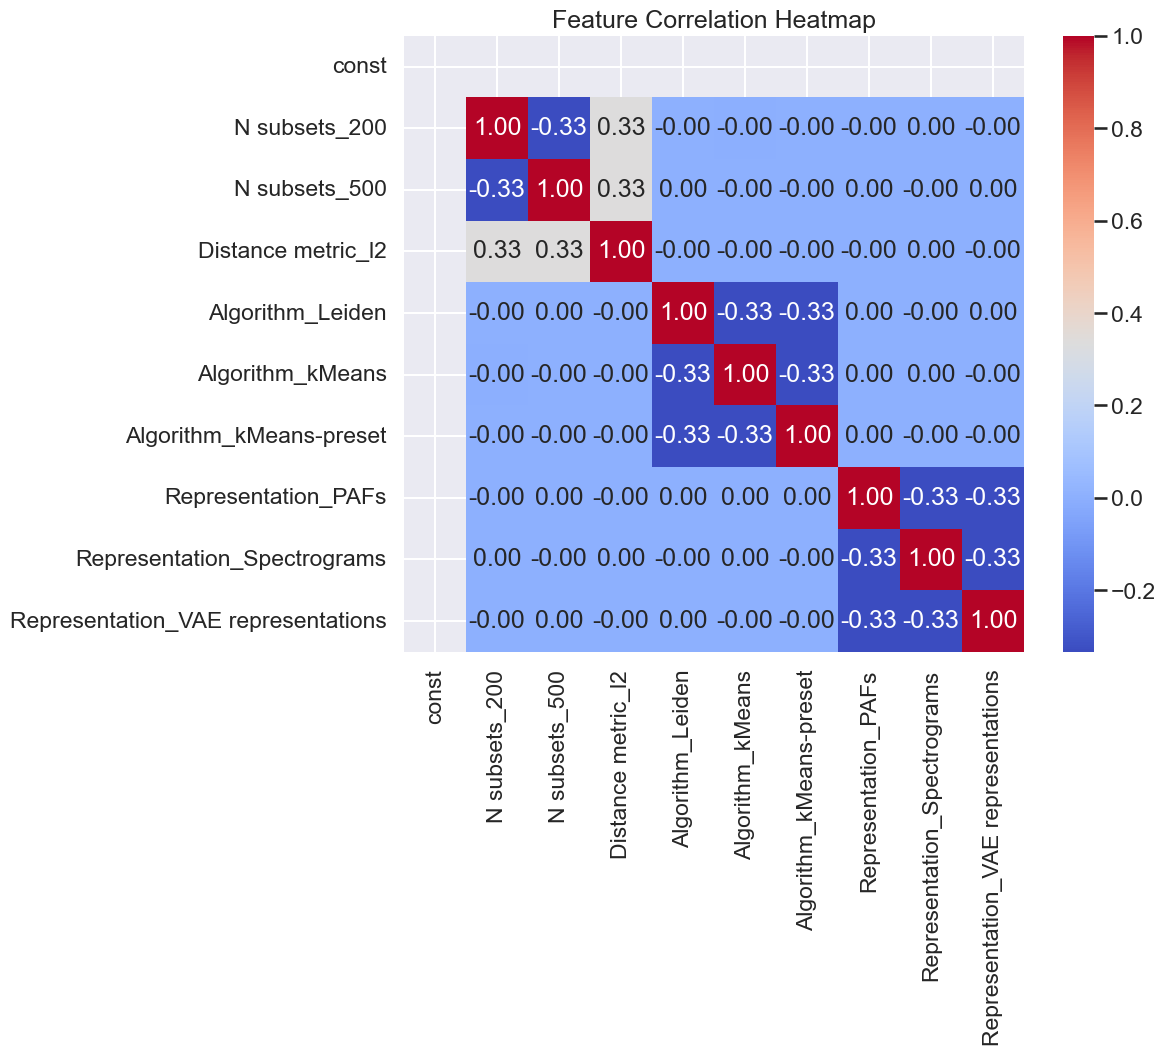

In [143]:
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [152]:
from sklearn.preprocessing import LabelEncoder

# Filter data
data = true_vs_pred_df[true_vs_pred_df["Alarm call subset"] == "yes"].copy()

# Initialize encoders separately for each categorical column
label_encoder_rep = LabelEncoder()
label_encoder_alg = LabelEncoder()
label_encoder_dist = LabelEncoder()

# label encoding
data["Representation"] = label_encoder_rep.fit_transform(data["Representation"])
data["Algorithm"] = label_encoder_alg.fit_transform(data["Algorithm"])
data["Distance metric"] = label_encoder_dist.fit_transform(data["Distance metric"])

# mean values for metrics
data["V measure"] = np.mean(data["V measure"].values[0])
data["Adj. RS"] = np.mean(data["Adj. RS"].values[0])
data["Homogeneity"] = np.mean(data["Homogeneity"].values[0])
data["Completeness"] = np.mean(data["Completeness"].values[0])

# Drop unnecessary columns
data = data.drop(columns=["p-value", "Chance level", "Alarm call subset"])

# Convert boolean columns to float
data = data.astype(float)

# Store label mappings
label_mappings = {
    "Representation": dict(zip(label_encoder_rep.classes_, label_encoder_rep.transform(label_encoder_rep.classes_))),
    "Algorithm": dict(zip(label_encoder_alg.classes_, label_encoder_alg.transform(label_encoder_alg.classes_))),
    "Distance metric": dict(zip(label_encoder_dist.classes_, label_encoder_dist.transform(label_encoder_dist.classes_)))
}


print(label_mappings)
data

{'Representation': {'LFCCs': 0, 'PAFs': 1, 'Spectrograms': 2, 'VAE representations': 3}, 'Algorithm': {'HDBSCAN': 0, 'Leiden': 1, 'kMeans': 2, 'kMeans-preset': 3}, 'Distance metric': {'l1': 0, 'l2': 1}}


N subsets  Distance metric  Representation  Algorithm  V measure  \
0        95.0              1.0             1.0        2.0   0.579544   
1        95.0              1.0             1.0        3.0   0.579544   
2        95.0              1.0             1.0        0.0   0.579544   
3        95.0              1.0             1.0        1.0   0.579544   
4        95.0              1.0             0.0        2.0   0.579544   
..        ...              ...             ...        ...        ...   
59      500.0              1.0             2.0        1.0   0.579544   
60      500.0              1.0             3.0        2.0   0.579544   
61      500.0              1.0             3.0        3.0   0.579544   
62      500.0              1.0             3.0        0.0   0.579544   
63      500.0              1.0             3.0        1.0   0.579544   

    Homogeneity  Completeness   Adj. RS  
0      0.600478      0.559657  0.493143  
1      0.600478      0.559657  0.493143  
2      0.600478      0.559657  0.493143  
3      0.600478      0.559657  0.493143  
4      0.600478      0.559657  0.493143  
..          ...           ...       ...  
59     0.600478      0.559657  0.493143  
60     0.600478      0.559657  0.493143  
61     0.600478      0.559657  0.493143  
62     0.600478      0.559657  0.493143  
63     0.600478      0.559657  0.493143  

[64 rows x 8 columns]

In [154]:
# Define predictors (independent variables) and target variable
X = data.drop(columns=['V measure', 'Homogeneity', 'Completeness', 'Adj. RS'])

# Add intercept term
X = sm.add_constant(X)

y = data['V measure']
glm_V = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_V.summary())

y = data['Adj. RS']
glm_RS = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_RS.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              V measure   No. Observations:                   64
Model:                            GLM   Df Residuals:                       59
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.467
Date:                Tue, 11 Feb 2025   Deviance:                   2.0172e-15
Time:                        16:52:24   Pearson chi2:                 9.24e-28
No. Iterations:                     3   Pseudo R-squ. (CS):          1.110e-16
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3209      0.717     

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


In [157]:
# Define predictors (independent variables) and target variable
X = data.drop(columns=['V measure', 'Homogeneity', 'Completeness', 'Adj. RS'])

# Add intercept term
X = sm.add_constant(X)

y = data['V measure']
glm_V = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_V.summary())

y = data['Adj. RS']
glm_RS = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_RS.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              V measure   No. Observations:                   64
Model:                            GLM   Df Residuals:                       62
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.467
Date:                Tue, 11 Feb 2025   Deviance:                  -1.0336e-14
Time:                        16:53:55   Pearson chi2:                 5.18e-29
No. Iterations:                     3   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3209      0.424      0.

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
